# Empirical Analysis

# Table of Contents

* [Section 1: Static Analysis, constant $\beta$](#static_analysis)

    * [Section 1.1: Static OLS](#static_ols)
  
        * [Section 1.1.1: Daily]
    
        * [Section 1.1.2: Weekly]
    
        * [Section 1.1.3: Weekday]
        
    * [Section 1.2: Subsample Analysis](#subsample)
  
        * [Section 1.2.1: Daily]
    
        * [Section 1.2.2: Weekly]
    
        * [Section 1.2.3: Weekday]
        
    * [Section 1.3: Autocorrelation Investigation](#static_auto)
        
        * [Section 1.3.1: Daily]
    
        * [Section 1.3.2: Weekly]
    
        * [Section 1.3.3: Weekday]
    
    * [Section 1.4: Adjusted Case Numbers](#static_adjust_case)
        
        * [Section 1.4.1: Daily]
    
        * [Section 1.4.2: Weekly]
    
        * [Section 1.4.3: Weekday]   
        
       
* [Section 2: Dynamic Analysis, time-varying $\beta$](#dynamic_analysis)

     * [Section 2.1: Rolling OLS](#dynamic_rolling_ols)
    
        * [Section 2.1.1: Daily]
  
        * [Section 2.1.2: Weekly]
  
        * [Section 2.1.3: Weekday]
        
     * [Section 2.2: Score Model](#dynamic_score_model)

        * [Section 2.2.1: Daily]
    
        * [Section 2.2.2: Weekly]
      
        * [Section 2.2.3: Weekday]
      
     * [Section 2.3: Score Out-of-sample Forecast](#dynamic_out_sample)
     
        * [Section 2.3.1: Daily]
   
        * [Section 2.3.2: Weekly]
  
        * [Section 2.3.3: Weekday]
      
     * [Section 2.4: Score Adjusted Case Numbers](#dynamic_adjust_case)
      
        * [Section 2.4.1: Daily]
 
        * [Section 2.4.2: Weekly]
  
        * [Section 2.4.3: Weekday]
        
     * [Section 2.5: Autocorrelation Investigation](#dynamic_auto)
        
        * [Section 2.5.1: Daily]
        
        * [Section 2.5.2: Weekly]
        
        * [Section 2.5.3: Weekday]
  
  
* [Section 3: Municipality Data Analysis, Panel Data](#muni_analysis)

     * [Section 3.1: Static Analysis](#muni_static_analysis)
    
         * [Section 3.1.1: Daily]
  
         * [Section 3.1.2: Weekly]
  
         * [Section 3.1.3: Weekday]
    
     * [Section 3.2: Dynamic Analysis](#muni_dynamic_analysis)
    
         * [Section 3.2.1: Daily]
 
         * [Section 3.2.2: Weekly]
  
         * [Section 3.2.3: Weekday]
         
     * [Section 3.3: Explore Correlation between $\beta$ and Data](#beta_and_data)
  

In [44]:
using CSV, DataFrames, Plots, StatsPlots, Dates, GLM;
using Pipe, StatsPlots, Underscores, Statistics, StatsBase, RollingFunctions;

In [45]:
# import data and clean
date_of_first_obs = Date("2020-07-01");
windowsize = 7; # set window size for aggregating data into windowsize-ly data
sub_sample_size = 90;  # 3-months

daily = CSV.File("pos.csv") |> DataFrame;
n = nrow(daily);
delete!(daily, n-1:n);  # last two rows contain some words instead of data, remomve them
daily = rename(daily, :Tested => :Nt, :NewPositive => :Ct) |> DataFrame; # rename Nt and Ct
daily.Nt .= replace.(daily.Nt, "." => "");  # There are dots in numbers, i.e. one thousand is written as 1.000, remove dots
daily.Nt .= replace.(daily.Nt, " " => "");
daily.Ct .= replace.(daily.Ct, "." => "");
daily.Ct .= replace.(daily.Ct, " " => "");
daily.Nt = parse.(Int, daily.Nt); # change data type from string to integers
daily.Ct = parse.(Int, daily.Ct);
daily.logNt = log.(daily.Nt); # create log(Nt)
daily.logCt = log.(daily.Ct); # create log(Ct)
daily.ratio = daily.Ct ./ daily.Nt; # calculate positive ratio
daily.ratio = replace!(daily.ratio, NaN => 0); # NaN are created bc some Nt=0, replace NaN with 0
daily.Date = Date.(daily.Date, "yyyy-mm-dd"); # change data type of Date from string to Date
n = nrow(daily);

# create daily data set 
national_daily = @pipe daily |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
select(_, :Date, :logCt, :logNt, :Ct, :Nt) |>
transform(_, :logCt => (x -> x - lag(x)) => :diff_logCt, 
             :logNt => (x -> x - lag(x)) => :diff_logNt) |>
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_daily = nrow(national_daily);

# create rolling weekly data set
national_weekly = select(daily,
    :Date,
    :Nt => (v -> runmean(v, windowsize) * windowsize) => :Nt, 
    :Ct => (v -> runmean(v, windowsize) * windowsize) => :Ct)
delete!(national_weekly, 1: (windowsize - 1));
national_weekly = @pipe national_weekly |> 
transform(_, :Nt => (x -> log.(x)) => :logNt,
             :Ct => (x -> log.(x)) => :logCt) |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
transform(_, :logCt => (x -> x - lag(x)) => :diff_logCt, 
             :logNt => (x -> x - lag(x)) => :diff_logNt) |> 
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_weekly = nrow(national_weekly);

# create weekday data set, 7-day difference
national_7dd = @pipe daily |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
select(_, :Date, :logCt, :logNt, :Ct, :Nt) |>
transform(_, :logCt => (x -> x - lag(x, 7)) => :diff_logCt, 
             :logNt => (x -> x - lag(x, 7)) => :diff_logNt) |>
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_7dd = nrow(national_7dd);

# add sub-sample index to data sets
national_daily.subsample = string.(Int.(repeat(1:ceil(N_daily/sub_sample_size), 
            inner = sub_sample_size)[1:N_daily]));
national_weekly.subsample = string.(Int.(repeat(1:ceil(N_weekly/sub_sample_size), 
            inner = sub_sample_size)[1:N_weekly]));
national_7dd.subsample = string.(Int.(repeat(1:ceil(N_7dd/sub_sample_size), 
            inner = sub_sample_size)[1:N_7dd]));

# Section 1: Static Analysis, constant $\beta$ <a class="anchor" id="static_analysis"></a>

Define $N_t$ as number of tests conducted at day $t$; $C_t$ as number of observed positive cases at day $t$.

Let $c_t = \log C_t$ and $n_t = \log N_t$, then 

$$\Delta c_t = \beta \Delta n_t + U_t.$$

In each of the subsections below, there will be time plots of the key variables, scatter plots of $\Delta c_t$ against
$\Delta n_t$, OLS estimation results; where in the scatter plots, the vertical and horizontal lines show the 0.5% and 99.5% quantile of x and y axis respectively.

## Section 1.1: Static OLS<a class="anchor" id="static_ols"></a>

### Section 1.1.1: Daily

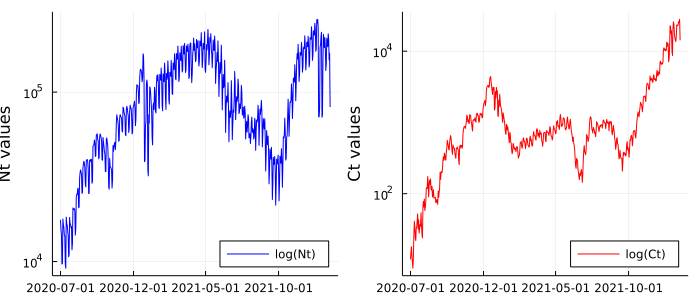

In [46]:
pnt_daily = @df national_daily plot(:Date, :Nt, yaxis = :log, ylabel = "Nt values",
    label = "log(Nt)", color = "blue", leg = :bottomright);
pct_daily = @df national_daily plot(:Date, :Ct, yaxis = :log, ylabel = "Ct values",
    label = "log(Ct)", color = "red", leg = :bottomright);
plot(pnt_daily, pct_daily, layout = (1, 2), size = (700, 300))

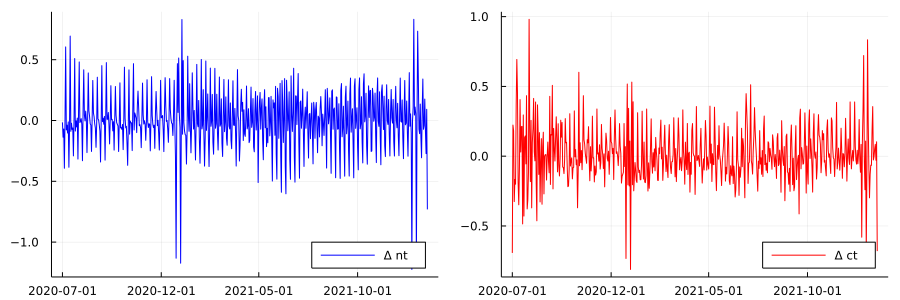

In [47]:
pdnt_daily = @df national_daily plot(:Date, :diff_logNt, 
    label = "Δ nt", color = "blue", leg = :bottomright);
pdct_daily = @df national_daily plot(:Date, :diff_logCt, 
    label = "Δ ct", color = "red", leg = :bottomright);
plot(pdnt_daily, pdct_daily, layout = (1, 2), size = (900, 300))

In [48]:
ols_national_daily = lm(@formula(diff_logCt ~ diff_logNt), national_daily)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

diff_logCt ~ 1 + diff_logNt

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)    Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  0.00990655  0.00656366   1.51    0.1318  -0.00298567  0.0227988
diff_logNt   0.510409    0.0272842   18.71    <1e-60   0.456818    0.564
────────────────────────────────────────────────────────────────────────────

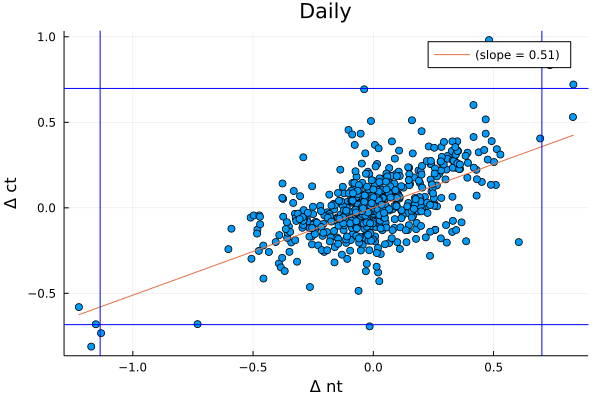

In [49]:
@df national_daily scatter(:diff_logNt, :diff_logCt, label=:none)
@df national_daily plot!(:diff_logNt, :diff_logNt * coef(ols_national_daily)[2], 
                      label = string("(slope = ",round(coef(ols_national_daily)[2], digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = "Daily")
@df national_daily hline!([quantile(:diff_logCt, 0.005)], color = :blue, label=:none)
@df national_daily hline!([quantile(:diff_logCt, 0.995)], color = :blue, label=:none)
@df national_daily vline!([quantile(:diff_logNt, 0.005)], color = :blue, label=:none)
@df national_daily vline!([quantile(:diff_logNt, 0.995)], color = :blue, label=:none)

### Section 1.1.2: Weekly

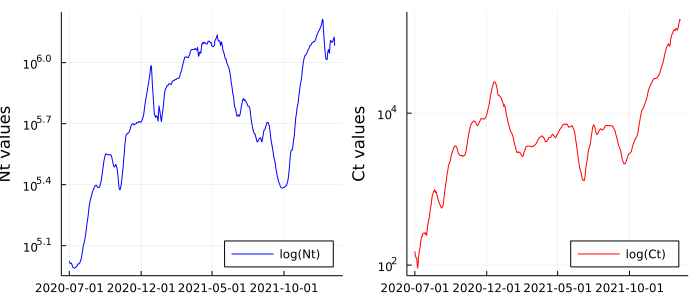

In [50]:
pnt_weekly = @df national_weekly plot(:Date, :Nt, yaxis = :log, ylabel = "Nt values",
    label = "log(Nt)", color = "blue", leg = :bottomright);
pct_weekly = @df national_weekly plot(:Date, :Ct, yaxis = :log, ylabel = "Ct values",
    label = "log(Ct)", color = "red", leg = :bottomright);
plot(pnt_weekly, pct_weekly, layout = (1, 2), size = (700, 300))

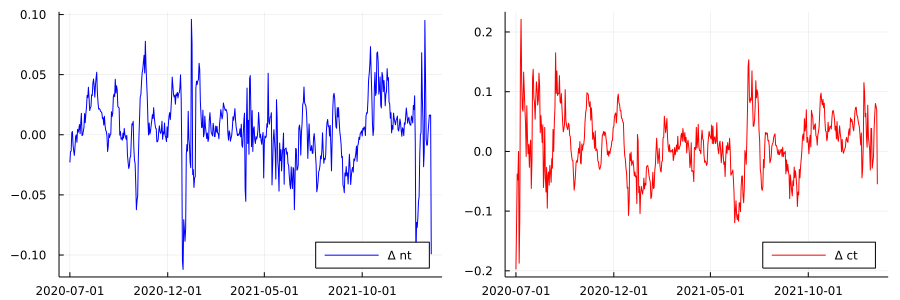

In [51]:
pdnt_weekly = @df national_weekly plot(:Date, :diff_logNt, 
    label = "Δ nt", color = "blue", leg = :bottomright);
pdct_weekly = @df national_weekly plot(:Date, :diff_logCt, 
    label = "Δ ct", color = "red", leg = :bottomright);
plot(pdnt_weekly, pdct_weekly, layout = (1, 2), size = (900, 300))

In [52]:
ols_national_weekly = lm(@formula(diff_logCt ~ diff_logNt), national_weekly)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

diff_logCt ~ 1 + diff_logNt

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  0.00860766  0.00199302   4.32    <1e-04  0.00469303  0.0125223
diff_logNt   0.792863    0.0707895   11.20    <1e-25  0.65382     0.931906
───────────────────────────────────────────────────────────────────────────

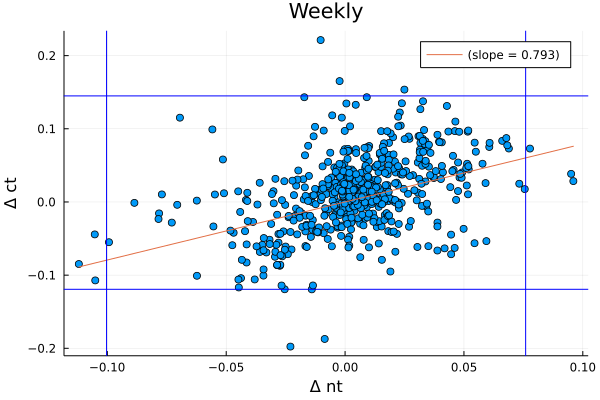

In [53]:
@df national_weekly scatter(:diff_logNt, :diff_logCt, label=:none)
@df national_weekly plot!(:diff_logNt, :diff_logNt * coef(ols_national_weekly)[2], 
                      label = string("(slope = ",round(coef(ols_national_weekly)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = "Weekly")
@df national_weekly hline!([quantile(:diff_logCt, 0.005)], color = :blue, label=:none)
@df national_weekly hline!([quantile(:diff_logCt, 0.995)], color = :blue, label=:none)
@df national_weekly vline!([quantile(:diff_logNt, 0.005)], color = :blue, label=:none)
@df national_weekly vline!([quantile(:diff_logNt, 0.995)], color = :blue, label=:none)

### Section 1.1.3: Weekday

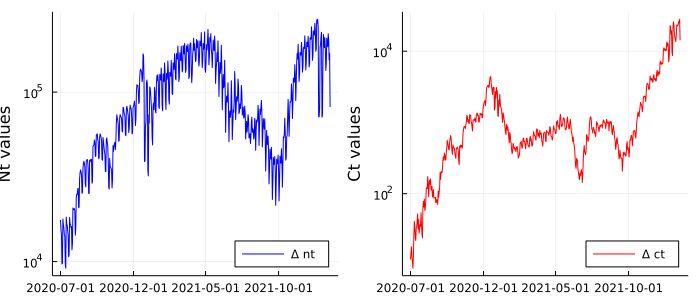

In [54]:
pdnt_7dd = @df national_7dd plot(:Date, :Nt, yaxis = :log, ylabel = "Nt values",
    label = "Δ nt", color = "blue", leg = :bottomright);
pdct_7dd = @df national_7dd plot(:Date, :Ct, yaxis = :log, ylabel = "Ct values",
    label = "Δ ct", color = "red", leg = :bottomright);
plot(pdnt_7dd, pdct_7dd, layout = (1, 2), size = (700, 300))

In [55]:
ols_national_7dd = lm(@formula(diff_logCt ~ diff_logNt), national_7dd)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

diff_logCt ~ 1 + diff_logNt

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.0627919   0.0136272   4.61    <1e-05  0.0360256  0.0895582
diff_logNt   0.733013    0.0619546  11.83    <1e-28  0.611323   0.854703
─────────────────────────────────────────────────────────────────────────

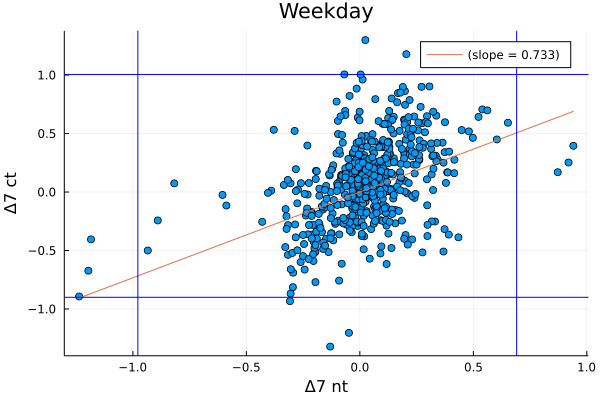

In [56]:
@df national_7dd scatter(:diff_logNt, :diff_logCt, label=:none)
@df national_7dd plot!(:diff_logNt, :diff_logNt * coef(ols_national_7dd)[2], 
                      label = string("(slope = ",round(coef(ols_national_7dd)[2],digits=3), ")"),
                       xlabel = "Δ7 nt",
                      ylabel = "Δ7 ct",
                      title = "Weekday")
@df national_7dd hline!([quantile(:diff_logCt, 0.005)], color = :blue, label=:none)
@df national_7dd hline!([quantile(:diff_logCt, 0.995)], color = :blue, label=:none)
@df national_7dd vline!([quantile(:diff_logNt, 0.005)], color = :blue, label=:none)
@df national_7dd vline!([quantile(:diff_logNt, 0.995)], color = :blue, label=:none)

## Section 1.2: Subsample Analysis <a class="anchor" id="subsample"></a>

In this section, we divide the national data into subsamples, and redo the static analysis.

### Section 1.2.1: Daily 

In [57]:
lm(@formula(diff_logCt ~ 0 + subsample + diff_logNt & subsample), national_daily)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

diff_logCt ~ 0 + subsample + diff_logNt & subsample

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                                Coef.  Std. Error      t  Pr(>|t|)    Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
subsample: 1                0.0277481   0.0160906   1.72    0.0852  -0.00385812  0.0593543
subsample: 2                0.0150365   0.0160637   0.94    0.3497  -0.0165168   0.0465899
subsample: 3               -0.0165061   0.0160672  -1.03    0.3047  -0.0480665   0.0150543
subsample: 4               -0.0130092   0.0160645  -0.81    0.4184  -0.0445642   0.0185458
subsample: 5                0.0109782   0.0160744   0.68    0.4949  -0.0205964   0.0425528
subsample: 6               

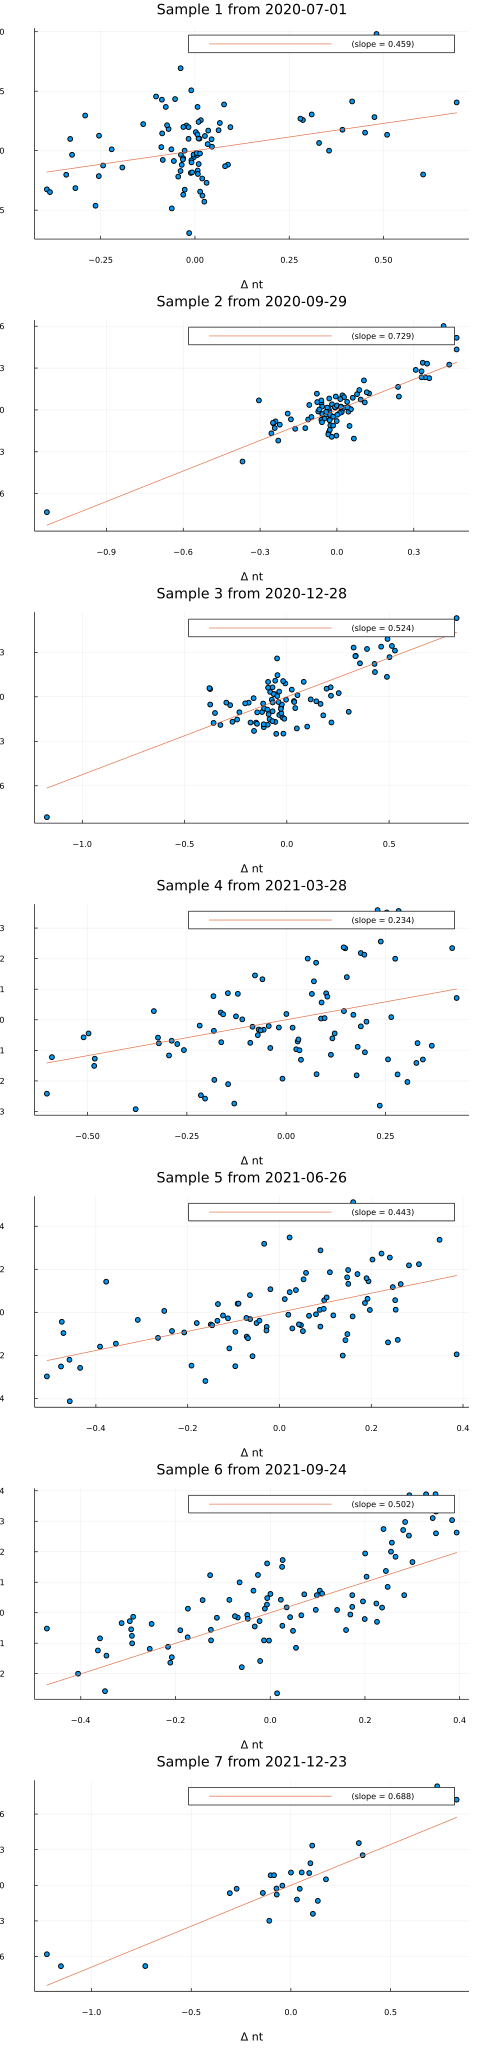

In [58]:
p = [];
national_daily_subsample = groupby(national_daily, :subsample);
p_i = 0;
for g in national_daily_subsample
    p_i = p_i + 1;
    start_date = g.Date[1];
    ols = lm(@formula(diff_logCt ~ diff_logNt), g);
    pg = @df g scatter(:diff_logNt, :diff_logCt, label=:none)
         @df g plot!(:diff_logNt, :diff_logNt * coef(ols)[2], 
                      label = string("(slope = ",round(coef(ols)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = string("Sample ", p_i, " from ", start_date))
    push!(p, pg)
end
plot(p..., size = (700, 3000), layout = (Int(length(p)), 1))

### Section 1.2.2: Weekly

In [59]:
lm(@formula(diff_logCt ~ 0 + subsample + diff_logNt & subsample), national_weekly)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

diff_logCt ~ 0 + subsample + diff_logNt & subsample

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                                 Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
subsample: 1                0.0177823   0.00570151   3.12    0.0019   0.00658302   0.0289817
subsample: 2                0.0118144   0.00464528   2.54    0.0113   0.0026898    0.020939
subsample: 3               -0.0149241   0.00468488  -3.19    0.0015  -0.0241265   -0.00572171
subsample: 4               -0.00627719  0.00484561  -1.30    0.1957  -0.0157953    0.00324089
subsample: 5                0.018381    0.0049316    3.73    0.0002   0.00869398   0.028068
subsampl

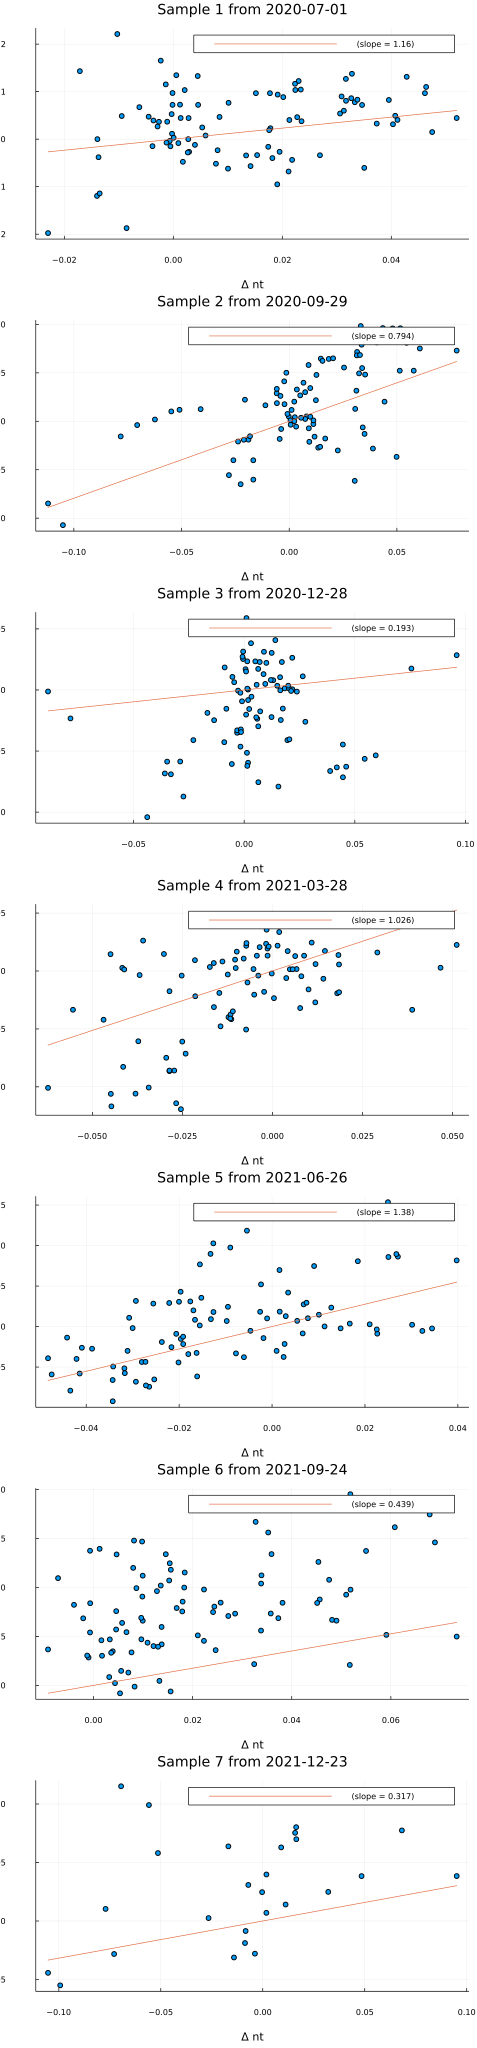

In [60]:
pW = [];
national_weekly_subsample = groupby(national_weekly, :subsample);
p_i = 0;
for g in national_weekly_subsample
    p_i = p_i + 1;
    start_date = g.Date[1];
    ols = lm(@formula(diff_logCt ~ diff_logNt), g);
    pg = @df g scatter(:diff_logNt, :diff_logCt, label=:none)
         @df g plot!(:diff_logNt, :diff_logNt * coef(ols)[2], 
                      label = string("(slope = ",round(coef(ols)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = string("Sample ", p_i, " from ", start_date))
    push!(pW, pg)
end
plot(pW..., size = (700, 3000), layout = (Int(length(p)), 1))

### Section 1.2.3: Weekday

In [61]:
lm(@formula(diff_logCt ~ 0 + subsample + diff_logNt & subsample), national_7dd)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

diff_logCt ~ 0 + subsample + diff_logNt & subsample

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                                Coef.  Std. Error      t  Pr(>|t|)     Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
subsample: 1                0.133457    0.0389051   3.43    0.0006   0.0570368     0.209877
subsample: 2                0.0937027   0.0311663   3.01    0.0028   0.0324837     0.154922
subsample: 3               -0.106495    0.0321614  -3.31    0.0010  -0.169668     -0.0433208
subsample: 4               -0.0452547   0.0329173  -1.37    0.1698  -0.109913      0.0194038
subsample: 5                0.130577    0.0334419   3.90    0.0001   0.0648879     0.196266
subsample: 6  

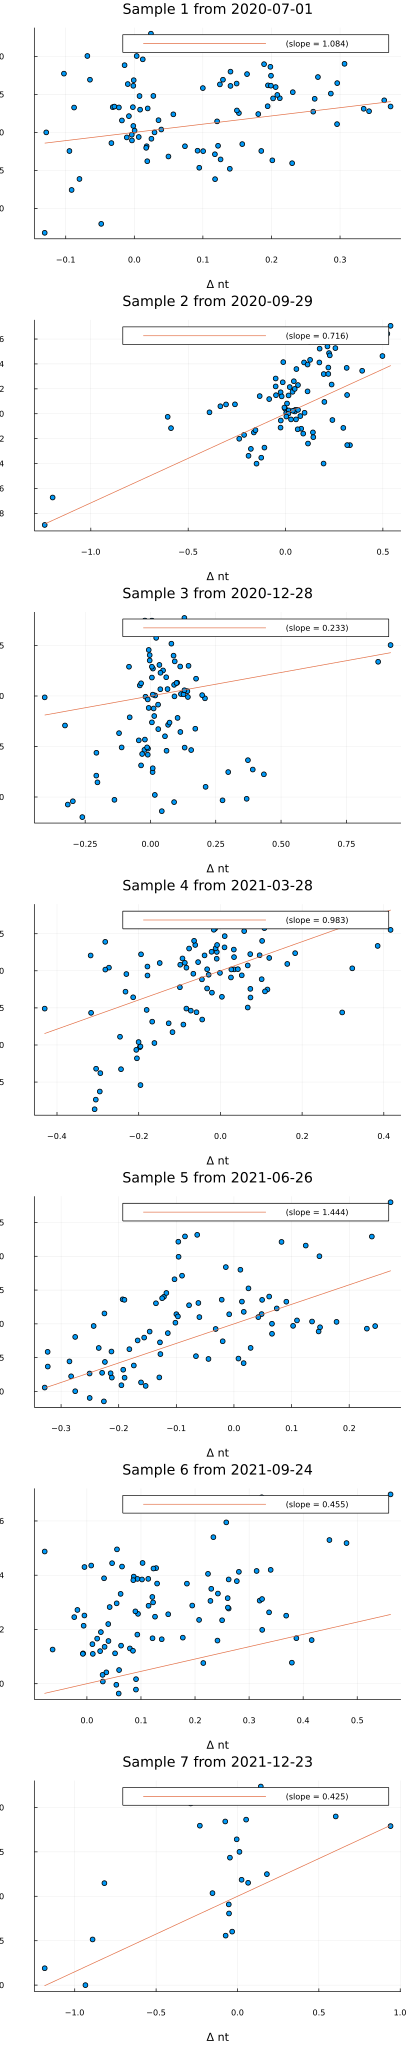

In [62]:
p7dd = [];
national_7dd_subsample = groupby(national_7dd, :subsample);
p_i = 0;
for g in national_7dd_subsample
    start_date = g.Date[1];
    p_i = p_i + 1;
    ols = lm(@formula(diff_logCt ~ diff_logNt), g);
    pg = @df g scatter(:diff_logNt, :diff_logCt, label=:none)
         @df g plot!(:diff_logNt, :diff_logNt * coef(ols)[2], 
                      label = string("(slope = ",round(coef(ols)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = string("Sample ", p_i, " from ", start_date))
    push!(p7dd, pg)
end
plot(p7dd..., size = (600, 3000), layout = (Int(length(p)), 1))

## Section 1.3: Autocorrelation Investigation<a class="anchor" id="static_auto"></a>

### Section 1.3.1: Daily

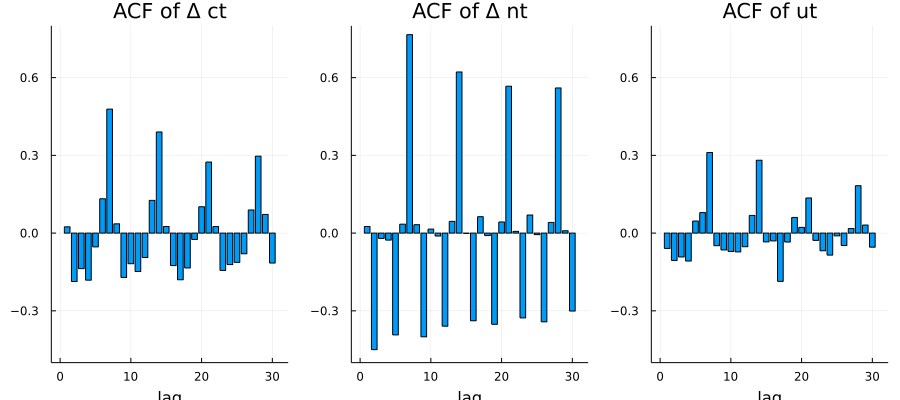

In [63]:
p1 = plot(bar(autocor(national_daily.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_daily.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_daily.ut = national_daily.diff_logCt .- national_daily.diff_logNt * coef(ols_national_daily)[2];
p3 = plot(bar(autocor(national_daily.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3),  ylims = (-0.5, 0.8), size = (900, 400))

### Section 1.3.2: Weekly

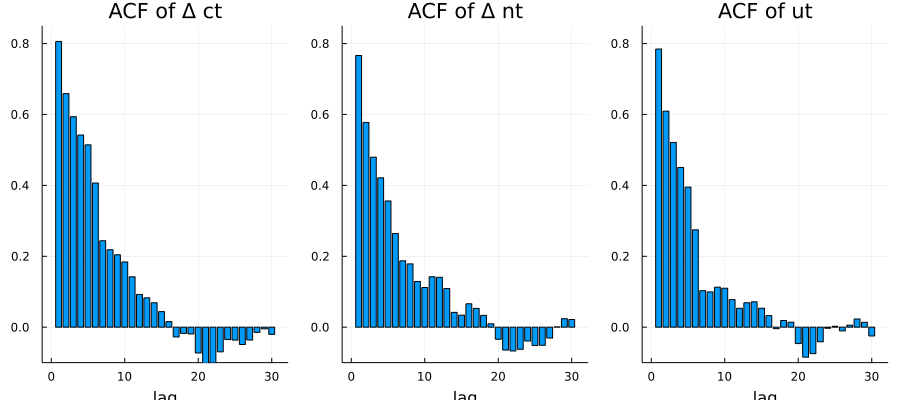

In [64]:
p1 = plot(bar(autocor(national_weekly.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_weekly.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_weekly.ut = national_weekly.diff_logCt .- national_weekly.diff_logNt * coef(ols_national_weekly)[2];
p3 = plot(bar(autocor(national_weekly.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.1, 0.85), size = (900, 400))

### Section 1.3.3: Weekday

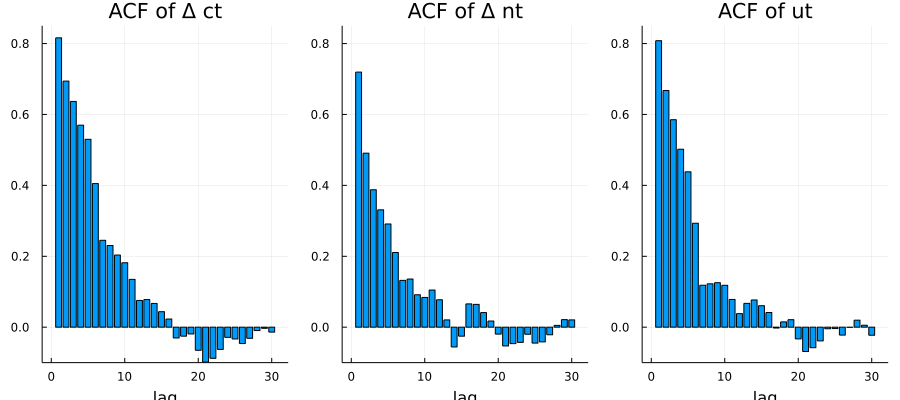

In [65]:
p1 = plot(bar(autocor(national_7dd.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_7dd.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_7dd.ut = national_7dd.diff_logCt .- national_7dd.diff_logNt * coef(ols_national_7dd)[2];
p3 = plot(bar(autocor(national_7dd.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.1, 0.85), size = (900, 400))

## Section 1.4: Adjusted Case Numbers<a class="anchor" id="static_adjust_case"></a>

For a fixed N,

$$\tilde{C} = C \left( \frac{N}{N_t} \right)^{\hat{\beta}}.$$

### Section 1.4.1: Daily

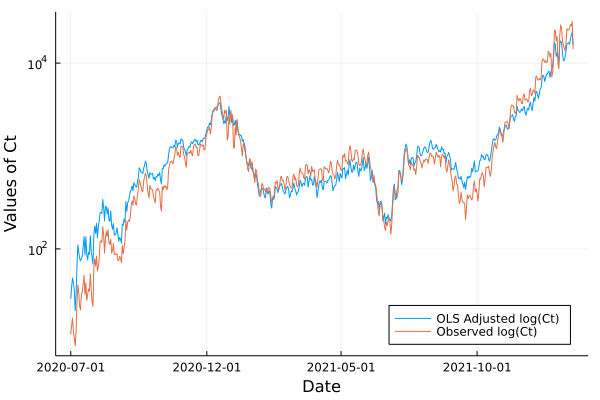

In [138]:
fixN_daily = 100000;
national_daily.C_tilde = national_daily.Ct .* (fixN_daily ./ national_daily.Nt) .^ coef(ols_national_daily)[2];
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_daily) plot(:Date, :C_tilde, yaxis = :log, 
    label = "OLS Adjusted log(Ct)", xlabel = "Date", ylabel = "Values of Ct")
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_daily) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 1.4.2: Weekly

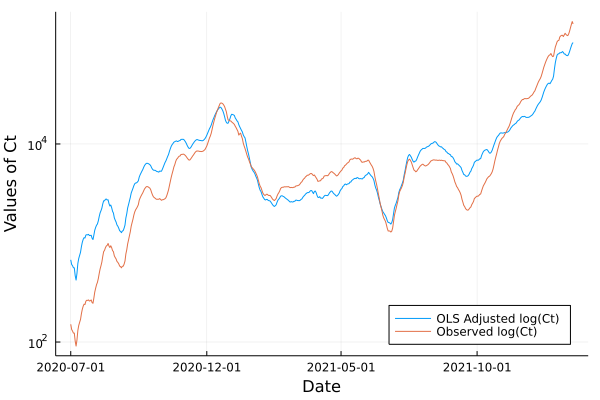

In [140]:
fixN_weekly = fixN_daily * 7;
national_weekly.C_tilde = national_weekly.Ct .* (fixN_weekly ./ national_weekly.Nt) .^ coef(ols_national_weekly)[2];
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_weekly) plot(:Date, :C_tilde, yaxis = :log, 
    label = "OLS Adjusted log(Ct)", xlabel = "Date", ylabel = "Values of Ct")
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_weekly) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 1.4.3: Weekday

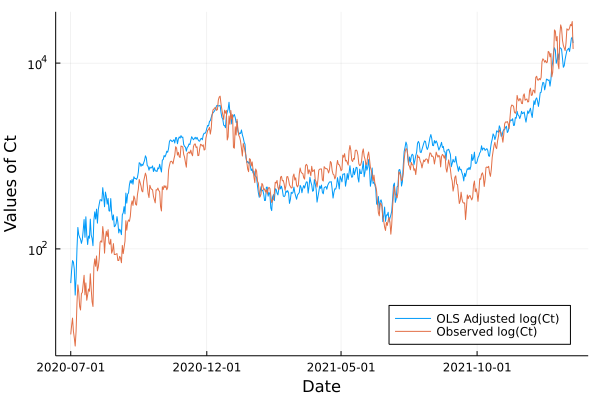

In [141]:
fixN_7dd = fixN_daily;
national_7dd.C_tilde = national_7dd.Ct .* (fixN_7dd ./ national_7dd.Nt) .^ coef(ols_national_7dd)[2];
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_7dd) plot(:Date, :C_tilde, yaxis = :log, 
    label = "OLS Adjusted log(Ct)", xlabel = "Date", ylabel = "Values of Ct")
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_7dd) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

# Section 2: Dynamic Analysis, time-varying $\beta$ <a class="anchor" id="dynamic_analysis"></a>

## Section 2.1: Rolling OLS <a class="anchor" id="dynamic_rolling_ols"></a>

In [69]:
nobs = 30;  # Number of observation in each estimation window, bigger window smoother

roll_beta_national_daily = [];
roll_beta_national_weekly = [];
roll_beta_national_7dd = [];

for i in 1:(N_daily - nobs + 1)
    v = @pipe national_daily[i : i + nobs - 1, :] |>
    lm(@formula(diff_logCt ~ diff_logNt), _) |>
    coef(_)[2] |>
    round(_, digits = 3)
    push!(roll_beta_national_daily, v)
end


for i in 1:(N_weekly - nobs + 1)
    v = @pipe national_weekly[i : i + nobs - 1, :] |>
    lm(@formula(diff_logCt ~ diff_logNt), _) |>
    coef(_)[2] |>
    round(_, digits = 3)
    push!(roll_beta_national_weekly, v)
end

for i in 1:(N_7dd - nobs + 1)
    v = @pipe national_7dd[i : i + nobs - 1, :] |>
    lm(@formula(diff_logCt ~ diff_logNt), _) |>
    coef(_)[2] |>
    round(_, digits = 3)
    push!(roll_beta_national_7dd, v)
end

### Section 2.1.1: Daily 

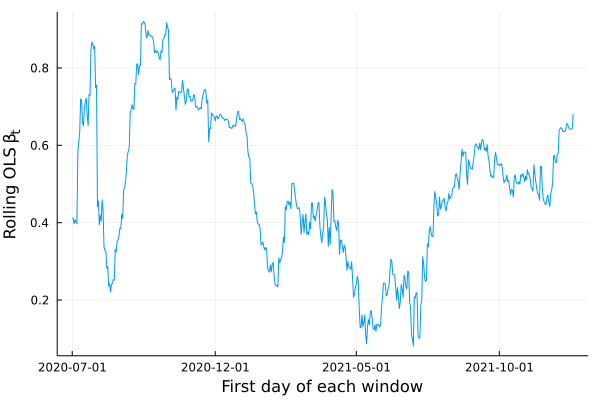

In [70]:
plot(national_daily.Date[1:(N_daily - nobs + 1)], roll_beta_national_daily, 
label = :none,
xlabel = "First day of each window",
ylabel = "Rolling OLS \\beta_t")

### Section 2.1.2: Weekly

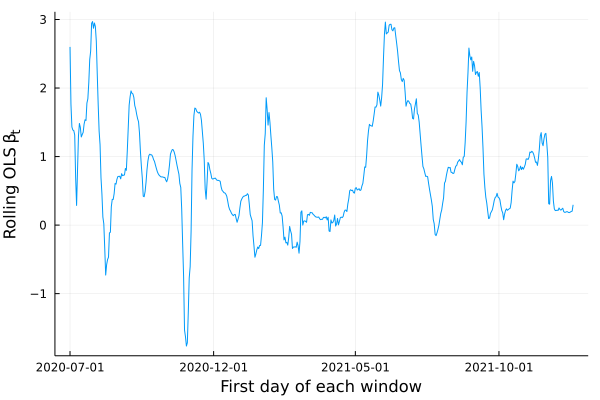

In [71]:
plot(national_weekly.Date[1:(N_weekly - nobs + 1)], roll_beta_national_weekly, 
label = :none,
xlabel = "First day of each window",
ylabel = "Rolling OLS \\beta_t")

### Section 2.1.3: Weekday

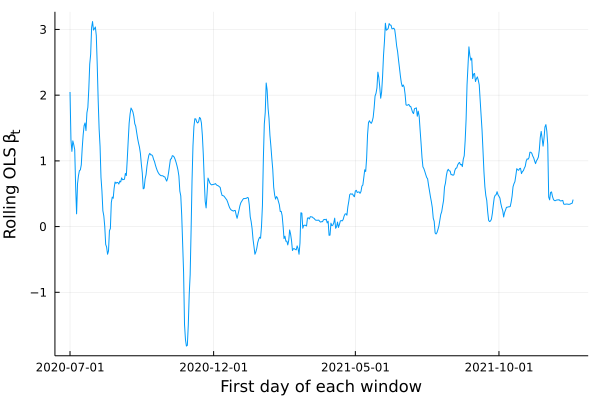

In [72]:
plot(national_7dd.Date[1:(N_7dd - nobs + 1)], roll_beta_national_7dd, 
label = :none,
xlabel = "First day of each window",
ylabel = "Rolling OLS \\beta_t")

## Section 2.2: Score Model<a class="anchor" id="dynamic_score_model"></a>


Assume normal errors, $\Delta \log \hat{C_t^*} \sim N(0, \sigma^2)$. 

Simplify notation, $y_t = \Delta \log C_t$ and $x_t = \Delta \log N_t$.

The log-likelihood is:

$$\ell(\beta_t) \propto - T \log(\sigma^2) - \sum_{t=1}^T \frac{(y_t - \beta_t x_t)^2}{\sigma^2};$$

The score is:

$$\frac{\partial \ell}{\partial \beta_t} = \frac{1}{\sigma^2} (y_t - \beta_t x_t) x_t;$$

The hessian is:

$$\frac{\partial^2 \ell}{\partial \beta_t^2} = - \frac{1}{\sigma^2} x_t^2;$$

Define
$$\psi(\beta_t) =
\frac{\frac{\partial \ell}{\partial \beta_t}}{\sqrt{- \frac{\partial^2 \ell}{\partial \beta_t^2}}}
=
\frac{\frac{1}{\sigma^2} (y_t - \beta_t x_t) x_t}{\sqrt{\frac{1}{\sigma^2} x_t^2}}
= 
\frac{1}{\sigma} \text{sign}(x_t) (y_t - \beta_t x_t)
$$

The model is (new version):

$$\beta_{t+1} = \omega + \phi \beta_t + \alpha \psi(\beta_t)
=
\omega + \phi \beta_t + \alpha \frac{\text{sign}(x_t) (y_t - \beta_t x_t)}{\sigma} 
$$

In [73]:
using Optim;
function ScoreBeta(θ, data)
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    ω = θ[1]; 
    ϕ = θ[2];
    α = θ[3]; 
    σ = θ[4];
    β0 = θ[5];
    β = [];  
    # Checked by CS people, this step is totally fine, wouldn't make any difference to memory or speed.
    # During optimazition process, this beta will be cleared after every update.
    push!(β, β0)  
    
    for i in 1:(T-1)
        v = ω + ϕ * β[i] + α * sign(x[i]) * (y[i] - β[i] * x[i]) / σ
        push!(β, v)
    end
    
    return β
end

function logL(θ, data)
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    β = ScoreBeta(θ, data);
    σ = θ[4];
    sum((y .- β .* x).^2)/(σ^2) + T*log(σ^2)   # Note: This is negative logL, not logL.
end

logL (generic function with 1 method)

Coding notes: 

The two chunks below are just to show that even if the function logL is called and successfully operated, the middle-product variable $\beta$ will not be kept, but rather be dropped. So the $\beta$ created within the function takes no memory space at all during the optimization process. On the other hand, if a global $\beta$ is created outside the function and then get updated, it will take some place, though very small.

In [74]:
logL([0, 1, 1, 0.2, 0.6], national_daily)

13263.29320797359

In [75]:
β

LoadError: UndefVarError: β not defined

### Section 2.2.1: Daily

In [76]:
θ_national_daily = [0, 1, 1, 0.2, 0.6];
obj_national_daily = θ_national_daily -> logL(θ_national_daily, national_daily) 
res_national_daily = optimize(obj_national_daily, θ_national_daily)
Optim.minimizer(res_national_daily)  # Estimated parameters

5-element Vector{Float64}:
  0.057013423304839196
  0.8944177403096213
  0.015785166294634747
  0.1548698313956388
 -0.2704652161139389

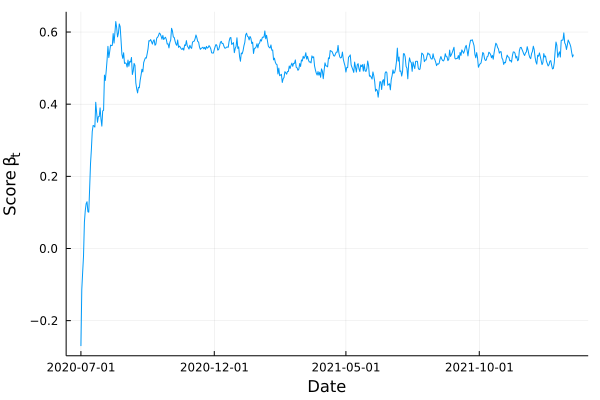

In [77]:
ScoreBetaHat_national_daily = ScoreBeta(Optim.minimizer(res_national_daily), national_daily);
plot(national_daily.Date, ScoreBetaHat_national_daily, 
label = :none,
xlabel = "Date",
ylabel = "Score \\beta_t")

### Section 2.2.2: Weekly

In [78]:
θ_national_weekly = [0, 1, 1, 0.2, 0.6];
obj_national_weekly = θ_national_weekly -> logL(θ_national_weekly, national_weekly) 
res_national_weekly = optimize(obj_national_weekly, θ_national_weekly)
Optim.minimizer(res_national_weekly)  # Estimated parameters

5-element Vector{Float64}:
 0.23771521638434634
 0.6276096116374076
 0.6091871830238518
 0.03913044141286357
 8.84082448467399

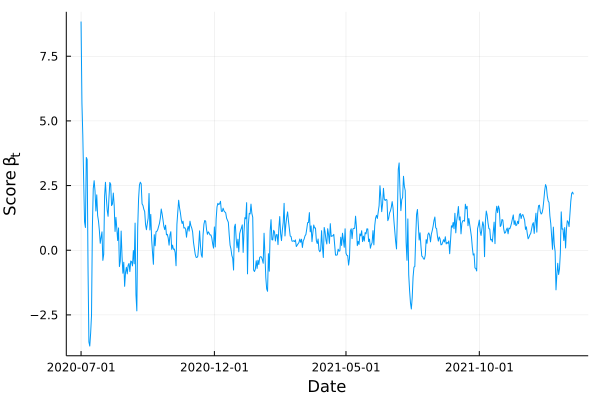

In [79]:
ScoreBetaHat_national_weekly = ScoreBeta(Optim.minimizer(res_national_weekly), national_weekly);
plot(national_weekly.Date, ScoreBetaHat_national_weekly, 
label = :none,
xlabel = "Date",
ylabel = "Score \\beta_t")

### Section 2.2.3: Weekday

In [80]:
θ_national_7dd = [0, 1, 1, 0.2, 0.6];
obj_national_7dd = θ_national_7dd -> logL(θ_national_7dd, national_7dd) 
res_national_7dd = optimize(obj_national_7dd, θ_national_7dd)
Optim.minimizer(res_national_7dd)  # Estimated parameters

5-element Vector{Float64}:
  0.23196043742525996
  0.6314205147295454
  0.44446268684502255
  0.27549854574532
 10.241647873395705

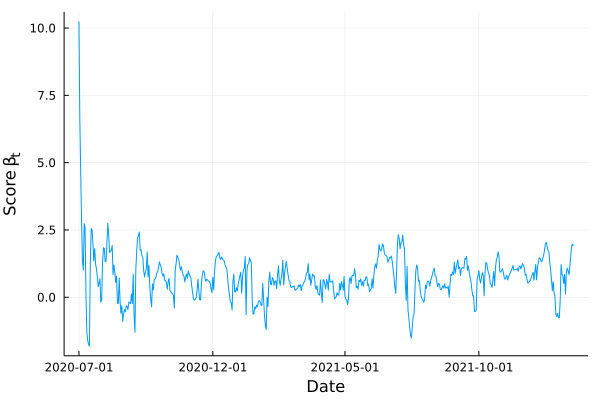

In [81]:
ScoreBetaHat_national_7dd = ScoreBeta(Optim.minimizer(res_national_7dd), national_7dd);
plot(national_7dd.Date, ScoreBetaHat_national_7dd, 
label = :none,
xlabel = "Date",
ylabel = "Score \\beta_t")

## Section 2.3: Score Out-of-sample Forecast<a class="anchor" id="dynamic_out_sample"></a>

The name "step" in my code means the sample size of data kept for out-of-sample forecast.

If step = 10, I estimate $\beta$ for 10 times. The first time, I use all data but the last 10 for estimation, and then make one out-of-sample forecast for the last 10th observation; The second time, I use all data but the last 9 for estimation, and only make one step ahead forecast for the last 9th observation; ... Repeat until I have all out-of-sample forecast for the 10 observations.

The graph shows observed $\Delta log C_t$ in blue and predicted in red. 

In [82]:
step = 100;  # choose sample size to be forecasted
function ScoreOutFcast(step, data)
    n = nrow(data);
    yhat = [];
    θ = [0, 1, 1, 0.2, 0.6];
    for i in 1:step
        ss = n - step + i - 1;
        train = data[1:ss, :];
        x = train.diff_logNt;
        y = train.diff_logCt;
        obj = θ -> logL(θ, train);
        res = optimize(obj, θ);
        θ = Optim.minimizer(res);
        β =  ScoreBeta(θ, train);
        ω = θ[1]; 
        ϕ = θ[2];
        α = θ[3];
        σ = θ[4];
        βt1 = ω + ϕ * β[ss] + α * sign(x[ss]) * (y[ss] - β[ss] * x[ss]) / σ;
        xt1 = data.diff_logNt[ss + 1];
        yt1hat = βt1 * xt1;
        push!(yhat, yt1hat)
    end
    return yhat
end    
ScoreYHat_national_daily = ScoreOutFcast(step, national_daily);
ScoreYHat_national_weekly = ScoreOutFcast(step, national_weekly);
ScoreYHat_national_7dd = ScoreOutFcast(step, national_7dd);

### Section 2.3.1: Daily

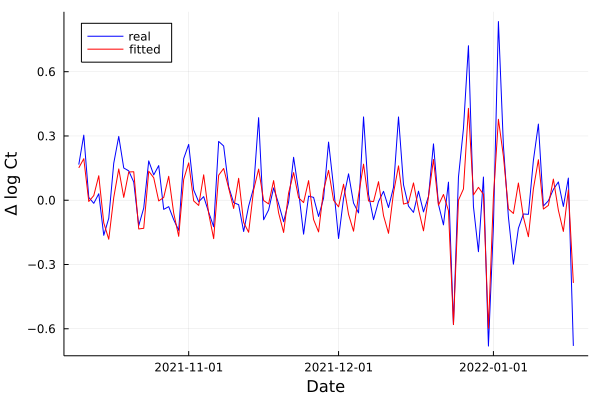

In [83]:
plot(national_daily.Date[N_daily - step + 1: N_daily], 
    national_daily.diff_logCt[N_daily - step + 1: N_daily],
    color = :blue,
    xlabel = "Date",
    ylabel = "\\Delta log Ct",
    label = "real")
plot!(national_daily.Date[N_daily - step + 1: N_daily], 
    ScoreYHat_national_daily,
    color = :red,
    label = "fitted", leg = :topleft)

### Section 2.3.2: Weekly

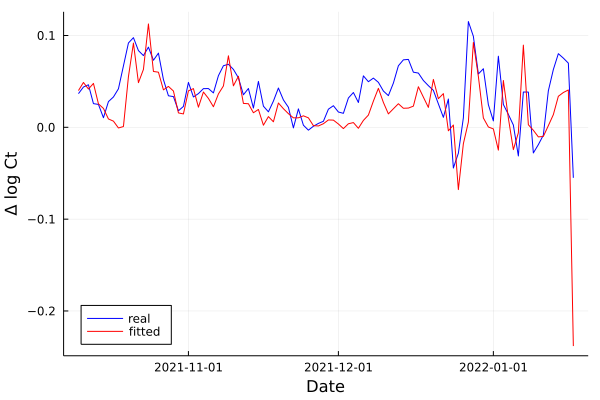

In [84]:
plot(national_weekly.Date[N_weekly - step + 1: N_weekly], 
    national_weekly.diff_logCt[N_weekly - step + 1: N_weekly],
    color = :blue,
    xlabel = "Date",
    ylabel = "\\Delta log Ct",
    label = "real")
plot!(national_weekly.Date[N_weekly - step + 1: N_weekly], 
    ScoreYHat_national_weekly,
    color = :red,
    label = "fitted", leg = :bottomleft)

### Section 2.3.3: Weekday

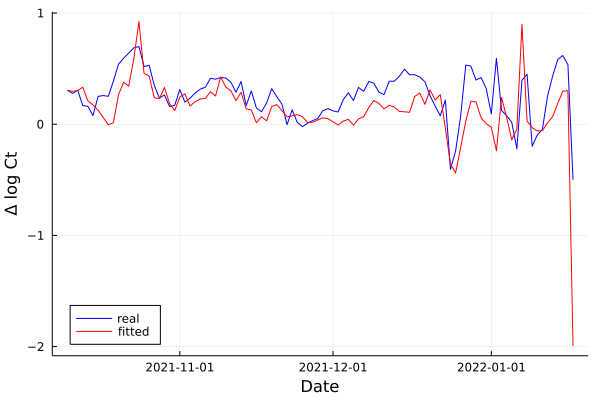

In [85]:
plot(national_7dd.Date[N_7dd - step + 1: N_7dd], 
    national_7dd.diff_logCt[N_7dd - step + 1: N_7dd],
    color = :blue,
    xlabel = "Date",
    ylabel = "\\Delta log Ct",
    label = "real")
plot!(national_7dd.Date[N_7dd - step + 1: N_7dd], 
    ScoreYHat_national_7dd,
    color = :red,
    label = "fitted", leg = :bottomleft)

## Section 2.4: Score Adjusted Case Numbers<a class="anchor" id="dynamic_adjust_case"></a>

$$\tilde{C} = C \left( \frac{N}{N_t} \right)^{\hat{\beta_t}}$$

### Section 2.4.1: Daily

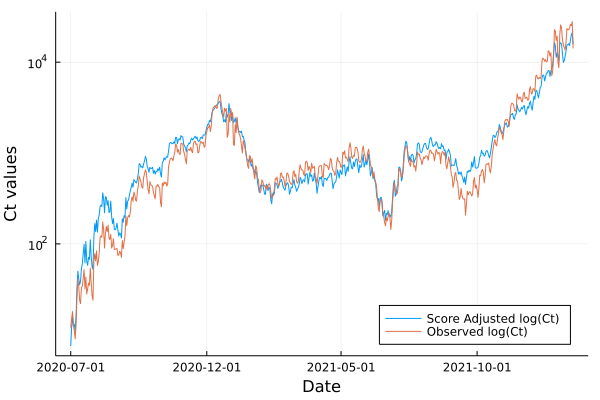

In [145]:
national_daily.ScoreBetaHat = ScoreBetaHat_national_daily;
national_daily.C_tilde_score = national_daily.Ct .* (fixN_daily ./ national_daily.Nt) .^ national_daily.ScoreBetaHat;

@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_daily) plot(:Date, :C_tilde_score, yaxis = :log, 
    label = "Score Adjusted log(Ct)", xlabel = "Date", ylabel = "Ct values")
@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_daily) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 2.4.2: Weekly

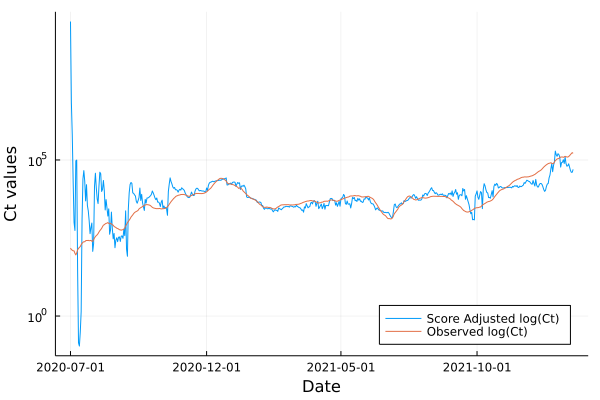

In [147]:
national_weekly.ScoreBetaHat = ScoreBetaHat_national_weekly;
national_weekly.C_tilde_score = national_weekly.Ct .* (fixN_weekly ./ national_weekly.Nt) .^ national_weekly.ScoreBetaHat;

@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_weekly) plot(:Date, :C_tilde_score, yaxis = :log, 
    label = "Score Adjusted log(Ct)", xlabel = "Date", ylabel = "Ct values")
@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_weekly) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 2.4.3: Weekday

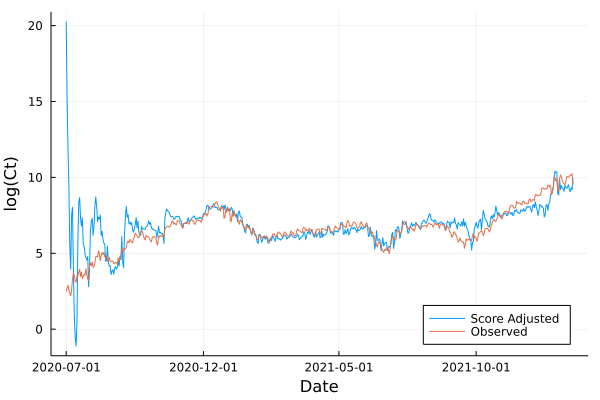

In [88]:
national_7dd.ScoreBetaHat = ScoreBetaHat_national_7dd;
national_7dd.C_tilde_score = national_7dd.Ct .* (fixN_7dd ./ national_7dd.Nt) .^ national_7dd.ScoreBetaHat;

@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_7dd) plot(:Date, :C_tilde_score, yaxis = :log, 
    label = "Score Adjusted", xlabel = "Date", ylabel = "log(Ct)")
@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_7dd) plot!(:Date, :logCt, 
    label = "Observed", leg = :bottomright)

## Section 2.5: Autocorrelation Investigation<a class="anchor" id="dynamic_auto"></a>

### Section 2.5.1:Daily

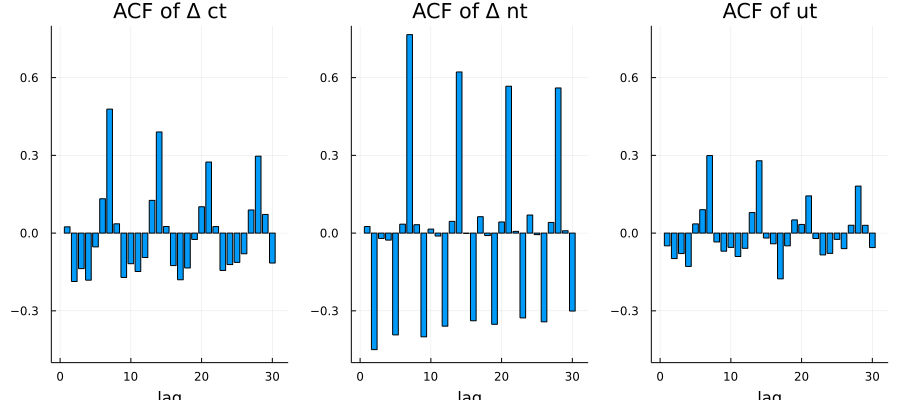

In [89]:
p1 = plot(bar(autocor(national_daily.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_daily.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_daily.ut = national_daily.diff_logCt .- national_daily.diff_logNt .* national_daily.ScoreBetaHat;
p3 = plot(bar(autocor(national_daily.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.5, 0.8), size = (900, 400))

### Section 2.5.2: Weekly

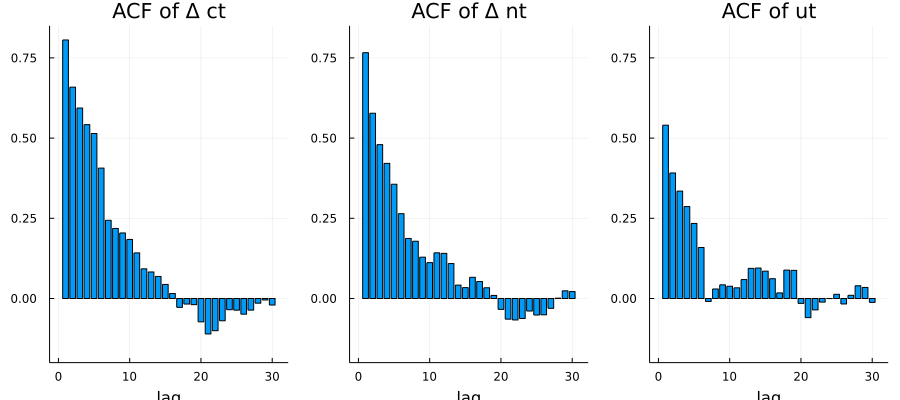

In [90]:
p1 = plot(bar(autocor(national_weekly.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_weekly.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_weekly.ut = national_weekly.diff_logCt .- national_weekly.diff_logNt .* national_weekly.ScoreBetaHat;
p3 = plot(bar(autocor(national_weekly.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.2, 0.85), size = (900, 400))

### Section 2.5.3: Weekday

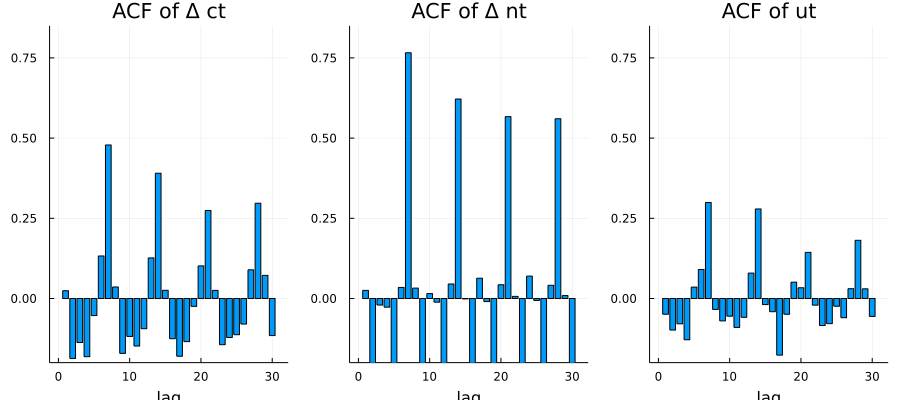

In [91]:
p1 = plot(bar(autocor(national_daily.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_daily.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_daily.ut = national_daily.diff_logCt .- national_daily.diff_logNt .* national_daily.ScoreBetaHat;
p3 = plot(bar(autocor(national_daily.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.2, 0.85), size = (900, 400))

# Section 3: Municipality Data Analysis, Panel Data<a class="anchor" id="muni_analysis"></a>

In [92]:
# Remove Municipalities with too few Nt (< 100 on average)
drop_cities = ["Christiansø", "Ærø", "Fanø", "Samsø", "Læsø", "NA"]

muni_Ct = @pipe CSV.File("Municipality_Ct.csv") |>
DataFrame |>
rename!(_, :SampleDate => :Date) |>
select(_, Not(drop_cities));
muni_Nt = @pipe CSV.File("Municipality_Nt.csv") |> 
DataFrame |>
rename!(_, :PrDate_adjusted => :Date) |>
select(_, Not(drop_cities));
muni_daily_level = @pipe innerjoin(muni_Ct, muni_Nt, on = :Date, makeunique=true);
## Notes: The orders of the columns in the two files are different.



# create daily data for model
df1 = @pipe muni_daily_level |>
transform(_, names(_, Not(:Date)) .=> (x -> log.(x)); renamecols=false);
for col in eachcol(df1)
    replace!(col, -Inf => 0)  # When initial numbers are 0, replace log of it to be 0 instead of -inf.
end
muni_daily = @pipe df1 |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

# create weekly data for model
muni_weekly_level = mapcols!(v -> runmean(v, windowsize) * windowsize, muni_daily_level[:, Not(:Date)]);
insertcols!(muni_weekly_level, 1, :Date => muni_daily_level.Date);
delete!(muni_weekly_level, 1: (windowsize - 1));
df2 = @pipe muni_weekly_level |>
transform(_, names(_, Not(:Date)) .=> (x -> log.(x)); renamecols=false);
for col in eachcol(df2)
    replace!(col, -Inf => 0)  # When initial numbers are 0, replace log of it to be 0 instead of -inf.
end
muni_weekly = @pipe df2 |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

# create weekday data for model
muni_7dd = @pipe df1 |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x, 7)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

## Section 3.1: Static Analysis<a class="anchor" id="muni_static_analysis"></a>

### Section 3.1.1: Daily

In [93]:
ols_muni_daily_coef = DataFrame(City = [], OlS_Intercept = [], OLS_Slope = Float64[], OLS_Slope_sd = []);
for i in 1 : Int((ncol(muni_daily)-1)/2)
    diff_logCt = muni_daily[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_daily)[i + 1]  
    diff_logNt = muni_daily[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    OLS = lm(@formula(diff_logCt ~ diff_logNt), data)
    coef_w_name = @pipe round.(coef(OLS), digits = 4) |> 
    vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
    vcat([city_name], _)
    push!(ols_muni_daily_coef, coef_w_name);
end
ols_muni_daily_coef

94×4 DataFrame
 Row │ City           OlS_Intercept  OLS_Slope  OLS_Slope_sd 
     │ Any            Any            Float64    Any          
─────┼───────────────────────────────────────────────────────
   1 │ Roskilde       0.0059            0.6392  0.054
   2 │ Copenhagen     0.007             0.8003  0.0309
   3 │ Aarhus         0.0089            0.7801  0.0341
   4 │ Frederiksberg  0.0069            0.7091  0.0557
   5 │ Kalundborg     0.0038            0.5409  0.0389
   6 │ Middelfart     0.0045            0.6245  0.0573
   7 │ Gentofte       0.0069            0.7399  0.0615
   8 │ Solrød         0.0036            0.5582  0.0524
   9 │ Allerød        0.0025            0.3413  0.0771
  10 │ Dragør         0.0029            0.4693  0.0627
  11 │ Helsingør      0.0055            0.5891  0.0619
  ⋮  │       ⋮              ⋮            ⋮           ⋮
  85 │ Lemvig         0.0014            0.2677  0.0584
  86 │ Albertslund    0.0042            0.5544  0.0665
  87 │ Bornholm       0.0031            0.337   0.0499
  88 │ Ikast-Brande   0.0038            0.4811  0.0603
  89 │ Langeland      0.0012            0.2507  0.0221
  90 │ Ringsted       0.0045            0.6191  0.0367
  91 │ Struer         0.0029            0.4434  0.0634
  92 │ Brønderslev    0.003             0.4034  0.0447
  93 │ Hedensted      0.0043            0.5791  0.0809
  94 │ Varde          0.0035            0.4531  0.0506
                                              73 rows omitted

### Section 3.1.2: Weekly

In [94]:
ols_muni_weekly_coef = DataFrame(City = [], OlS_Intercept = [], OLS_Slope = Float64[], OLS_Slope_sd = []);
for i in 1 : Int((ncol(muni_weekly)-1)/2)
    diff_logCt = muni_weekly[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_weekly)[i + 1]  
    diff_logNt = muni_weekly[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    OLS = lm(@formula(diff_logCt ~ diff_logNt), data)
    coef_w_name = @pipe round.(coef(OLS), digits = 4) |> 
    vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
    vcat([city_name], _)
    push!(ols_muni_weekly_coef, coef_w_name);
end
ols_muni_weekly_coef

94×4 DataFrame
 Row │ City           OlS_Intercept  OLS_Slope  OLS_Slope_sd 
     │ Any            Any            Float64    Any          
─────┼───────────────────────────────────────────────────────
   1 │ Roskilde       0.0097            0.7317  0.1621
   2 │ Copenhagen     0.0084            1.0072  0.0695
   3 │ Aarhus         0.0089            0.937   0.1321
   4 │ Frederiksberg  0.0083            1.1113  0.1276
   5 │ Kalundborg     0.009             0.7826  0.184
   6 │ Middelfart     0.0101            0.4799  0.1775
   7 │ Gentofte       0.0083            1.1034  0.1288
   8 │ Solrød         0.0085            0.6764  0.1745
   9 │ Allerød        0.0092            0.5471  0.1923
  10 │ Dragør         0.0071            1.0276  0.1485
  11 │ Helsingør      0.0107            0.6724  0.1427
  ⋮  │       ⋮              ⋮            ⋮           ⋮
  85 │ Lemvig         0.0092            0.4501  0.1883
  86 │ Albertslund    0.0083            0.2691  0.144
  87 │ Bornholm       0.0081            0.6555  0.1582
  88 │ Ikast-Brande   0.0101            0.6513  0.2074
  89 │ Langeland      0.0082            0.5045  0.1923
  90 │ Ringsted       0.0087            0.815   0.1434
  91 │ Struer         0.0098            0.2467  0.1776
  92 │ Brønderslev    0.0107            0.3735  0.1129
  93 │ Hedensted      0.0094            0.8541  0.1918
  94 │ Varde          0.0094            0.8712  0.1835
                                              73 rows omitted

### Section 3.1.3: Weekday

In [95]:
ols_muni_7dd_coef = DataFrame(City = [], OlS_Intercept = [], OLS_Slope = Float64[], OLS_Slope_sd = []);
for i in 1 : Int((ncol(muni_7dd)-1)/2)
    diff_logCt = muni_7dd[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_7dd)[i + 1]  
    diff_logNt = muni_7dd[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    OLS = lm(@formula(diff_logCt ~ diff_logNt), data)
    coef_w_name = @pipe round.(coef(OLS), digits = 4) |> 
    vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
    vcat([city_name], _)
    push!(ols_muni_7dd_coef, coef_w_name);
end
ols_muni_7dd_coef

94×4 DataFrame
 Row │ City           OlS_Intercept  OLS_Slope  OLS_Slope_sd 
     │ Any            Any            Float64    Any          
─────┼───────────────────────────────────────────────────────
   1 │ Roskilde       0.0514            0.8333  0.0625
   2 │ Copenhagen     0.0601            0.965   0.0411
   3 │ Aarhus         0.0642            0.8354  0.0503
   4 │ Frederiksberg  0.0556            0.9452  0.0631
   5 │ Kalundborg     0.0394            0.7428  0.0705
   6 │ Middelfart     0.0416            0.6815  0.0706
   7 │ Gentofte       0.0512            0.9059  0.066
   8 │ Solrød         0.0364            0.6714  0.0795
   9 │ Allerød        0.0398            0.471   0.078
  10 │ Dragør         0.0314            0.6393  0.0707
  11 │ Helsingør      0.0505            0.7474  0.0716
  ⋮  │       ⋮              ⋮            ⋮           ⋮
  85 │ Lemvig         0.0338            0.5366  0.0547
  86 │ Albertslund    0.0381            0.7111  0.0733
  87 │ Bornholm       0.0435            0.5781  0.0556
  88 │ Ikast-Brande   0.0453            0.6916  0.0755
  89 │ Langeland      0.0338            0.381   0.0434
  90 │ Ringsted       0.0394            0.6537  0.0668
  91 │ Struer         0.0376            0.4565  0.0624
  92 │ Brønderslev    0.0462            0.5364  0.0549
  93 │ Hedensted      0.0446            0.7318  0.0857
  94 │ Varde          0.0459            0.671   0.0758
                                              73 rows omitted

## Section 3.2: Dynamic Analysis<a class="anchor" id="muni_dynamic_analysis"></a>
First restrict the intercept and slope in the socre equation to be 0 and 1 respectively.

The $\beta_0$ is also part of the parameters now.

In [96]:
# Restrict ω = 0, and ϕ = 1.
function Restricted_ScoreBeta(θ, data)
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    ω = 0;
    ϕ = 1;   
    α = θ[1]; 
    σ = θ[2];
    β0 = θ[3];
    β = [];
    push!(β, β0)  
    
    for i in 1:(T-1)
    v = ω + ϕ * β[i] + α * sign(x[i]) * (y[i] - β[i] * x[i]) / σ
    push!(β, v)
    end
    
    return β
end

function Restricted_logL(θ, data)
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    β = Restricted_ScoreBeta(θ, data);
    σ = θ[2];
    sum((y .- β .* x).^2)/(σ^2) + T*log(σ^2)   # Note: This is negative logL, not logL.
end

Restricted_logL (generic function with 1 method)

### Section 3.2.1: Daily

In [97]:
muni_daily_score_coef_restricted = DataFrame(City = String[], α = String[], σ = String[], β0 = String[]);
muni_daily_score_beta_restricted = DataFrame();
θ = [1, 0.2, 0.6];
for i in 1 : Int((ncol(muni_daily)-1)/2)
    diff_logCt = muni_daily[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_daily)[i + 1]  
    diff_logNt = muni_daily[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    obj = θ -> Restricted_logL(θ, data);
    res = optimize(obj, θ);
    coef_w_name = @pipe Optim.minimizer(res) |> round.(_, digits = 4) |> string.(_) |> append!([city_name],  _);
    push!(muni_daily_score_coef_restricted, coef_w_name);
    muni_daily_score_beta_restricted[!, city_name] = Restricted_ScoreBeta(Optim.minimizer(res), data);
end
insertcols!(muni_daily_score_beta_restricted, 1, :Date => muni_daily.Date);

In [98]:
muni_daily_score_coef_restricted

94×4 DataFrame
 Row │ City           α        σ       β0      
     │ String         String   String  String  
─────┼─────────────────────────────────────────
   1 │ Roskilde       -0.039   0.5113  0.0537
   2 │ Copenhagen     0.1069   0.2732  0.4496
   3 │ Aarhus         0.0649   0.3346  1.0217
   4 │ Frederiksberg  -0.0437  0.4677  0.8439
   5 │ Kalundborg     0.0411   0.6932  0.2548
   6 │ Middelfart     -0.041   0.6292  0.2141
   7 │ Gentofte       -0.0677  0.5198  0.6752
   8 │ Solrød         0.0117   0.655   0.2436
   9 │ Allerød        0.0119   0.6452  0.0018
  10 │ Dragør         0.0111   0.6105  0.1789
  11 │ Helsingør      0.0252   0.6056  0.2808
  ⋮  │       ⋮           ⋮       ⋮        ⋮
  85 │ Lemvig         0.038    0.5644  0.0192
  86 │ Albertslund    0.0319   0.6147  0.1214
  87 │ Bornholm       0.0398   0.5838  0.0831
  88 │ Ikast-Brande   0.0184   0.6274  0.0995
  89 │ Langeland      0.079    0.4498  0.0005
  90 │ Ringsted       0.0182   0.6685  0.4997
  91 │ Struer         -0.0435  0.5865  0.1301
  92 │ Brønderslev    0.0455   0.6843  0.1195
  93 │ Hedensted      -0.0655  0.6768  0.251
  94 │ Varde          -0.0358  0.6655  0.0143
                                73 rows omitted

In [99]:
muni_daily_score_beta_restricted

605×95 DataFrame
 Row │ Date        Roskilde   Copenhagen  Aarhus    Frederiksberg  Kalundborg  ⋯
     │ Date        Any        Any         Any       Any            Any         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2020-07-01  0.0537123  0.449561    1.02173   0.843926       0.254773    ⋯
   2 │ 2020-07-02  0.0540286  0.0193168   1.01932   0.846681       0.251449
   3 │ 2020-07-03  0.0545627  -0.742772   0.968505  0.9208         0.247952
   4 │ 2020-07-04  0.0553921  -0.517399   0.961686  0.860169       0.241221
   5 │ 2020-07-05  0.0576092  -0.534877   0.871912  0.874086       0.238233    ⋯
   6 │ 2020-07-06  0.0577801  -0.594376   0.856178  0.888627       0.237126
   7 │ 2020-07-07  0.0613559  -0.907294   0.750272  0.878222       0.224085
   8 │ 2020-07-08  0.0626647  -1.24531    0.740149  0.829862       0.216305
   9 │ 2020-07-09  0.0633981  -0.821496   0.737385  0.774085       0.213189    ⋯
  10 │ 2020-07-10  0.0635684  -0.650749   0.723762  0.720394       0.200894
  11 │ 2020-07-11  0.0637204  -0.829231   0.71371   0.722997       0.186063
  ⋮  │     ⋮           ⋮          ⋮          ⋮            ⋮            ⋮       ⋱
 596 │ 2022-02-16  0.812817   0.799943    0.71853   0.867663       0.645174
 597 │ 2022-02-17  0.793859   0.862567    0.726215  0.852261       0.648593    ⋯
 598 │ 2022-02-18  0.802507   0.916622    0.760749  0.837516       0.632867
 599 │ 2022-02-19  0.807256   0.933389    0.772963  0.850632       0.625153
 600 │ 2022-02-20  0.807204   0.852778    0.746689  0.853358       0.639418
 601 │ 2022-02-21  0.793894   0.864081    0.76212   0.849815       0.652745    ⋯
 602 │ 2022-02-22  0.8006     0.798332    0.744635  0.841036       0.666256
 603 │ 2022-02-23  0.796381   0.75175     0.749141  0.832837       0.686634
 604 │ 2022-02-24  0.798511   0.803882    0.739774  0.818505       0.673272
 605 │ 2022-02-25  0.77436    0.89733     0.778914  0.808889       0.746872    ⋯
                                                 89 columns and 584 rows omitted

### Section 3.2.2: Weekly

In [100]:
muni_weekly_score_coef_restricted = DataFrame(City = String[], α = String[], σ = String[], β0 = String[]);
muni_weekly_score_beta_restricted = DataFrame();
θ = [1, 0.2, 0.6];
for i in 1 : Int((ncol(muni_weekly)-1)/2)
    diff_logCt = muni_weekly[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_weekly)[i + 1]  
    diff_logNt = muni_weekly[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    obj = θ -> Restricted_logL(θ, data);
    res = optimize(obj, θ);
    coef_w_name = @pipe Optim.minimizer(res) |> round.(_, digits = 4) |> string.(_) |> append!([city_name],  _);
    push!(muni_weekly_score_coef_restricted, coef_w_name);
    muni_weekly_score_beta_restricted[!, city_name] = Restricted_ScoreBeta(Optim.minimizer(res), data);
end
insertcols!(muni_weekly_score_beta_restricted, 1, :Date => muni_weekly.Date);

In [101]:
muni_weekly_score_coef_restricted

94×4 DataFrame
 Row │ City           α        σ       β0      
     │ String         String   String  String  
─────┼─────────────────────────────────────────
   1 │ Roskilde       -0.1292  0.1304  1.7391
   2 │ Copenhagen     0.5493   0.0526  2.0797
   3 │ Aarhus         -0.0937  0.1161  3.0213
   4 │ Frederiksberg  0.1645   0.1055  0.1119
   5 │ Kalundborg     -0.1456  0.2043  0.9663
   6 │ Middelfart     0.0283   0.186   0.1098
   7 │ Gentofte       -0.073   0.1154  1.3624
   8 │ Solrød         -0.1101  0.1905  0.8205
   9 │ Allerød        0.1241   0.205   0.0555
  10 │ Dragør         -0.1137  0.1623  0.3219
  11 │ Helsingør      0.02     0.1464  0.871
  ⋮  │       ⋮           ⋮       ⋮        ⋮
  85 │ Lemvig         0.0223   0.2576  0.2045
  86 │ Albertslund    0.0321   0.1598  -0.8872
  87 │ Bornholm       0.02     0.2317  0.9925
  88 │ Ikast-Brande   0.0133   0.2101  0.5938
  89 │ Langeland      -0.1345  0.2827  0.0101
  90 │ Ringsted       -0.1046  0.1781  2.363
  91 │ Struer         0.0268   0.256   -0.207
  92 │ Brønderslev    -0.014   0.2135  0.5114
  93 │ Hedensted      -0.1186  0.1686  0.4552
  94 │ Varde          -0.1178  0.2017  0.3735
                                73 rows omitted

In [102]:
muni_weekly_score_beta_restricted

605×95 DataFrame
 Row │ Date        Roskilde  Copenhagen  Aarhus    Frederiksberg  Kalundborg   ⋯
     │ Date        Any       Any         Any       Any            Any          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2020-07-01  1.73913   2.07969     3.02125   0.111873       0.966345     ⋯
   2 │ 2020-07-02  1.75038   2.40397     2.96663   0.906615       1.00079
   3 │ 2020-07-03  1.75451   2.11853     2.91096   0.0394324      1.01775
   4 │ 2020-07-04  1.07494   1.00263     2.95768   0.385383       1.04032
   5 │ 2020-07-05  1.08198   1.61748     2.85123   0.383826       1.05359      ⋯
   6 │ 2020-07-06  1.08328   2.49621     3.54876   0.37941        1.06534
   7 │ 2020-07-07  1.12356   4.22325     3.58447   0.717275       1.14328
   8 │ 2020-07-08  1.15975   3.04126     3.32131   1.0603         1.14328
   9 │ 2020-07-09  1.18686   6.36531     3.36686   1.67747        1.14658      ⋯
  10 │ 2020-07-10  1.1939    6.43422     3.39476   1.03876        1.38208
  11 │ 2020-07-11  1.22966   3.88978     3.96686   1.03257        1.41731
  ⋮  │     ⋮          ⋮          ⋮          ⋮            ⋮            ⋮        ⋱
 596 │ 2022-02-16  0.885071  1.02876     0.935224  0.981916       0.990928
 597 │ 2022-02-17  0.880037  0.958368    0.924247  0.964231       0.974519     ⋯
 598 │ 2022-02-18  0.87403   0.795475    0.921387  0.948782       0.968522
 599 │ 2022-02-19  0.877584  0.860571    0.914428  0.923122       0.958887
 600 │ 2022-02-20  0.871798  0.83375     0.912566  0.917959       0.953139
 601 │ 2022-02-21  0.875952  0.838732    0.911285  0.926022       0.9441       ⋯
 602 │ 2022-02-22  0.88277   1.16865     0.896946  0.928462       0.902871
 603 │ 2022-02-23  0.836062  1.37541     0.879844  0.971961       0.881412
 604 │ 2022-02-24  0.838187  1.31795     0.860303  0.998873       0.881527
 605 │ 2022-02-25  0.836372  1.06658     0.852457  0.987657       0.886856     ⋯
                                                 89 columns and 584 rows omitted

### Section 3.2.3: Weekday

In [103]:
muni_7dd_score_coef_restricted = DataFrame(City = String[], α = String[], σ = String[], β0 = String[]);
muni_7dd_score_beta_restricted = DataFrame();
θ = [1, 0.2, 0.6];
for i in 1 : Int((ncol(muni_7dd)-1)/2)
    diff_logCt = muni_7dd[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_7dd)[i + 1]  
    diff_logNt = muni_7dd[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    obj = θ -> Restricted_logL(θ, data);
    res = optimize(obj, θ);
    coef_w_name = @pipe Optim.minimizer(res) |> round.(_, digits = 4) |> string.(_) |> append!([city_name],  _);
    push!(muni_7dd_score_coef_restricted, coef_w_name);
    muni_7dd_score_beta_restricted[!, city_name] = Restricted_ScoreBeta(Optim.minimizer(res), data);
end
insertcols!(muni_7dd_score_beta_restricted, 1, :Date => muni_7dd.Date);

In [104]:
muni_7dd_score_coef_restricted

94×4 DataFrame
 Row │ City           α        σ       β0      
     │ String         String   String  String  
─────┼─────────────────────────────────────────
   1 │ Roskilde       0.1502   0.5936  0.0043
   2 │ Copenhagen     0.1021   0.3971  1.0328
   3 │ Aarhus         0.4589   0.5595  1.2175
   4 │ Frederiksberg  0.248    0.5779  0.1949
   5 │ Kalundborg     0.0245   0.7358  0.4044
   6 │ Middelfart     0.0886   0.7058  -0.065
   7 │ Gentofte       0.0759   0.6176  0.4579
   8 │ Solrød         0.0105   0.7802  0.5086
   9 │ Allerød        0.0166   0.7404  -0.0279
  10 │ Dragør         0.0082   0.6852  0.4637
  11 │ Helsingør      0.0586   0.6969  0.122
  ⋮  │       ⋮           ⋮       ⋮        ⋮
  85 │ Lemvig         0.0378   0.6248  0.0198
  86 │ Albertslund    0.0087   0.7036  0.5404
  87 │ Bornholm       0.0451   0.6522  0.0679
  88 │ Ikast-Brande   0.0107   0.7279  0.4582
  89 │ Langeland      0.0414   0.4974  0.0302
  90 │ Ringsted       0.0111   0.7542  0.4846
  91 │ Struer         0.0769   0.7078  0.0012
  92 │ Brønderslev    0.0205   0.7963  0.1039
  93 │ Hedensted      -0.065   0.8002  0.3029
  94 │ Varde          0.0173   0.785   0.4991
                                73 rows omitted

In [105]:
muni_7dd_score_beta_restricted

605×95 DataFrame
 Row │ Date        Roskilde    Copenhagen  Aarhus     Frederiksberg  Kalundbor ⋯
     │ Date        Any         Any         Any        Any            Any       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2020-07-01  0.0042763   1.03285     1.21749    0.194908       0.40439   ⋯
   2 │ 2020-07-02  0.00423681  1.28619     1.71704    0.487633       0.40108
   3 │ 2020-07-03  0.00422044  1.26588     1.55718    0.125081       0.39908
   4 │ 2020-07-04  0.0041859   1.05278     1.38096    0.114219       0.395339
   5 │ 2020-07-05  0.00409723  1.16311     1.37345    0.113142       0.393188  ⋯
   6 │ 2020-07-06  0.00408152  1.32536     0.161144   0.109621       0.391442
   7 │ 2020-07-07  0.00388736  1.65846     0.152016   0.402646       0.385069
   8 │ 2020-07-08  0.00368473  1.49945     0.136352   0.397859       0.385069
   9 │ 2020-07-09  0.00356379  2.14523     0.125819   0.686096       0.384775  ⋯
  10 │ 2020-07-10  0.00353202  2.18753     0.118835   0.383456       0.369016
  11 │ 2020-07-11  0.00335722  1.83557     0.115682   0.378906       0.363573
  ⋮  │     ⋮           ⋮           ⋮           ⋮            ⋮            ⋮     ⋱
 596 │ 2022-02-16  0.747212    0.90912     1.10738    0.927158       0.758504
 597 │ 2022-02-17  0.765702    0.909002    1.10301    0.907356       0.766126  ⋯
 598 │ 2022-02-18  0.793799    0.898113    1.10348    0.914616       0.775455
 599 │ 2022-02-19  0.791252    0.913778    1.12675    0.869333       0.782371
 600 │ 2022-02-20  0.810709    0.902554    1.084      0.861635       0.788181
 601 │ 2022-02-21  0.798912    0.899046    1.06422    0.883331       0.792737  ⋯
 602 │ 2022-02-22  0.800297    0.947597    1.12114    0.887658       0.801272
 603 │ 2022-02-23  0.870175    0.984762    1.14943    0.960507       0.809338
 604 │ 2022-02-24  0.86088     1.01084     1.20481    1.0205         0.808948
 605 │ 2022-02-25  0.898635    1.04425     1.13795    1.02743        0.834936  ⋯
                                                 90 columns and 584 rows omitted

## Section 3.3: Explore Correlation between $\beta$ and Data <a class="anchor" id="beta_and_data"></a>

### Section 3.3.1: Daily

In [106]:
# Calculate positive-ratio for each municipality, panel data
muni_daily_PosRatio = DataFrame(); 
for i in 1 : Int((ncol(muni_daily_level)-1)/2)
    Ct = muni_daily_level[:, i+1];
    city_name = names(muni_daily_level)[i + 1];
    Nt = muni_daily_level[:, string(city_name, "_1")];
    ratio = Ct ./ Nt;
    muni_daily_PosRatio[!, city_name] = ratio;
end
insertcols!(muni_daily_PosRatio, 1, :Date => muni_daily_level.Date);
for col in eachcol(muni_daily_PosRatio)
    replace!(col, NaN => 0, Inf => 0);  # When Nt are 0, replace the ratio to be 0 instead of NaN and Inf.
end

# Create a dataframe contain averaged Nt and PosRatio and OLS estimates, cross-sectional data
d1 = @pipe DataFrame(City = names(muni_Nt, Not(:Date)),
          AveNt = mean.(eachcol(muni_Nt[:, Not(:Date)]))); 
d2 = @pipe DataFrame(City = names(muni_daily_PosRatio, Not(:Date)),
          AveRatio = Float64.(mean.(eachcol(muni_daily_PosRatio[:, Not(:Date)]))));
ols_nt_ratio_muni_daily = @pipe leftjoin(ols_muni_daily_coef, d1, on = :City) |> 
leftjoin(_, d2, on = :City);

#### Cross-sectional
The x-axis in plot below is averaged $N_t$ over time for all cities, and y-aix is the city's corresponding $\beta$ estimates. I expect there is negative relationship between the two, but the plot shows the opposite.

Cross-sectional OLS:

$\beta_i = a_0 + a_1 \bar{r}_i + a_2 \log(\bar{N}_i) + e_i$,

where $i$ is each municipality, 
$\bar{r}_i$ is averaged positive ratio over time for municipality $i$,
$\bar{N}_i$ is averaged $N_t$ over time for municipality $i$.

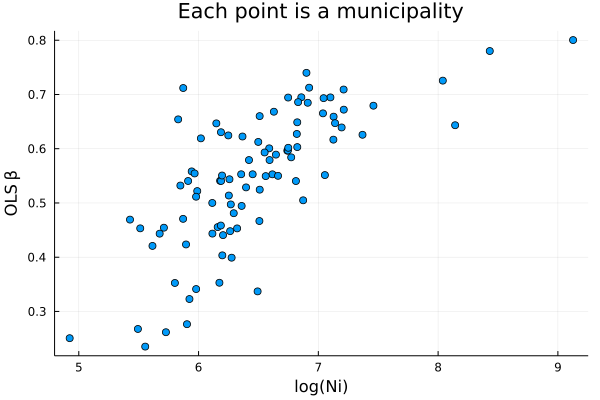

In [107]:
@df ols_nt_ratio_muni_daily scatter(log.(:AveNt), :OLS_Slope, 
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

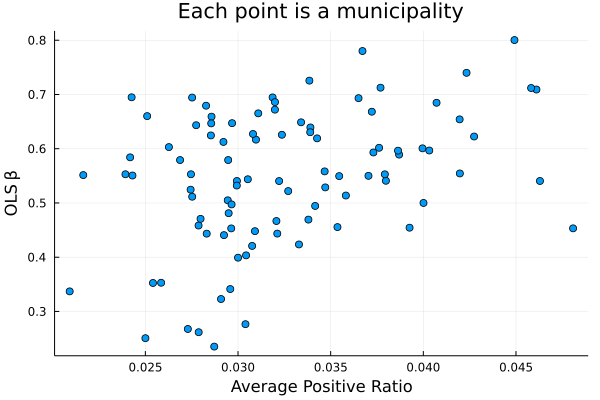

In [108]:
@df ols_nt_ratio_muni_daily scatter(:AveRatio, :OLS_Slope, 
    label = :none, 
    xlabel = "Average Positive Ratio", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [109]:
ols_muni_daily_beta_ratio_cross_sectional = lm(@formula(OLS_Slope ~ AveRatio + log(AveNt)), 
    ols_nt_ratio_muni_daily)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

OLS_Slope ~ 1 + AveRatio + :(log(AveNt))

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -0.48987    0.0907793  -5.40    <1e-06  -0.670192  -0.309548
AveRatio      5.86221    1.42455     4.12    <1e-04   3.03252    8.6919
log(AveNt)    0.130821   0.0129045  10.14    <1e-15   0.105188   0.156455
─────────────────────────────────────────────────────────────────────────

In [110]:
ols_nt_ratio_muni_daily.cs_ols_res = residuals(ols_muni_daily_beta_ratio_cross_sectional);
@df filter(:AveNt => v -> v <= 2000, ols_nt_ratio_muni_daily) scatter(log.(:AveNt), :cs_ols_res,
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "Cross-sectional OLS residuals", title = "Each point is a municipality");

#### Time-series

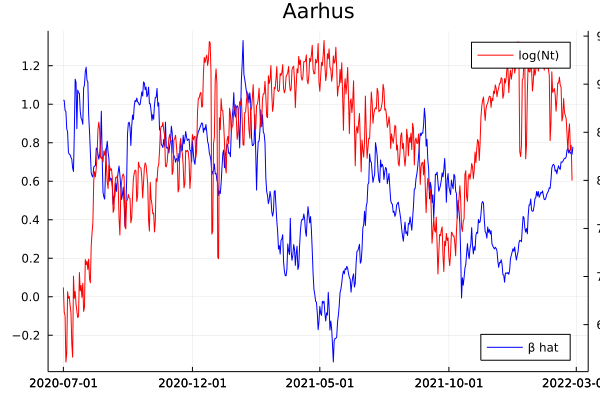

In [111]:
Aarhus = @pipe innerjoin(select(muni_Nt, :Date, "Aarhus" => "Nt"), 
    select(muni_daily_score_beta_restricted, :Date, "Aarhus" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aarhus" => "Ct"), 
    on = :Date => :Date);
Aarhus.PosRatio = Aarhus.Ct ./ Aarhus.Nt;
@df Aarhus plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aarhus", color = "blue", leg = :bottomright)
@df Aarhus plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

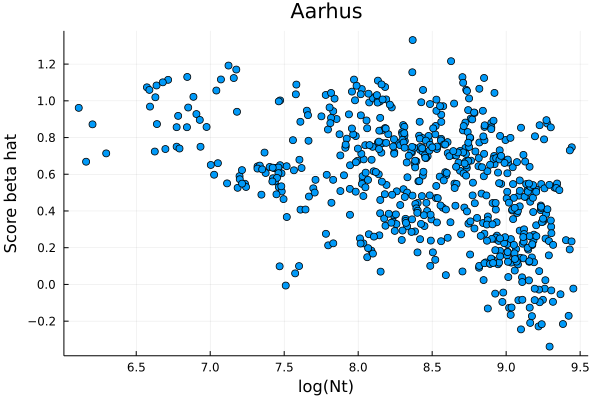

In [112]:
@df Aarhus scatter(log.(:Nt), :ScoreBetaHat, label = :none, 
    title = "Aarhus", xlabel = "log(Nt)", ylabel = "Score beta hat")

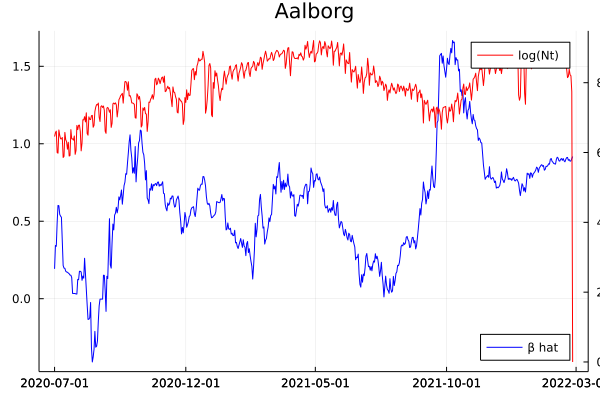

In [113]:
Aalborg = @pipe innerjoin(select(muni_Nt, :Date, "Aalborg" => "Nt"), 
    select(muni_daily_score_beta_restricted, :Date, "Aalborg" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aalborg" => "Ct"), 
    on = :Date => :Date);
Aalborg.PosRatio = Aalborg.Ct ./ Aalborg.Nt;
@df Aalborg plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aalborg", color = "blue", leg = :bottomright)
@df Aalborg plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

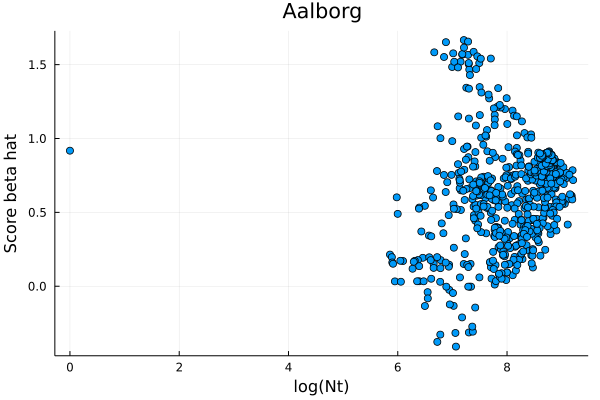

In [114]:
@df Aalborg scatter(log.(:Nt), :ScoreBetaHat, label = :none, 
    title = "Aalborg", xlabel = "log(Nt)", ylabel = "Score beta hat")

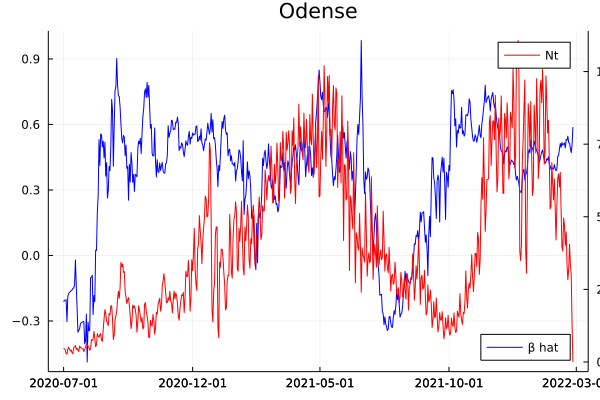

In [115]:
Odense = @pipe innerjoin(select(muni_Nt, :Date, "Odense" => "Nt"), 
    select(muni_daily_score_beta_restricted, :Date, "Odense" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Odense" => "Ct"), 
    on = :Date => :Date);
Odense.PosRatio = Odense.Ct ./ Odense.Nt;
@df Odense plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Odense", color = "blue", leg = :bottomright)
@df Odense plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

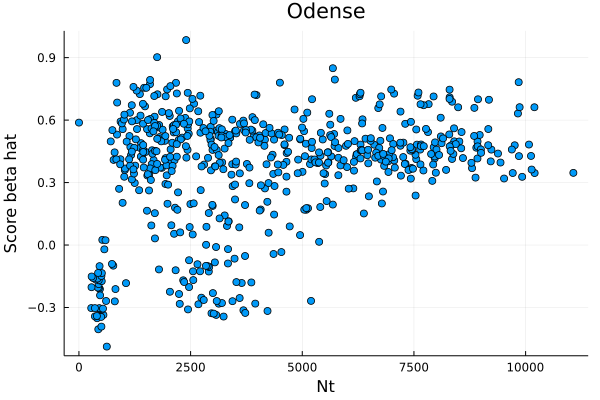

In [116]:
@df Odense scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Odense", xlabel = "Nt", ylabel = "Score beta hat")

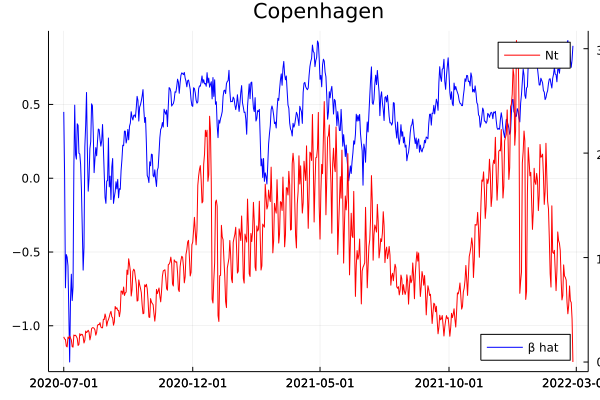

In [117]:
Copenhagen = @pipe innerjoin(select(muni_Nt, :Date, "Copenhagen" => "Nt"), 
    select(muni_daily_score_beta_restricted, :Date, "Copenhagen" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Copenhagen" => "Ct"), 
    on = :Date => :Date);
Copenhagen.PosRatio = Copenhagen.Ct ./ Copenhagen.Nt;
@df Copenhagen plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Copenhagen", color = "blue", leg = :bottomright)
@df Copenhagen plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

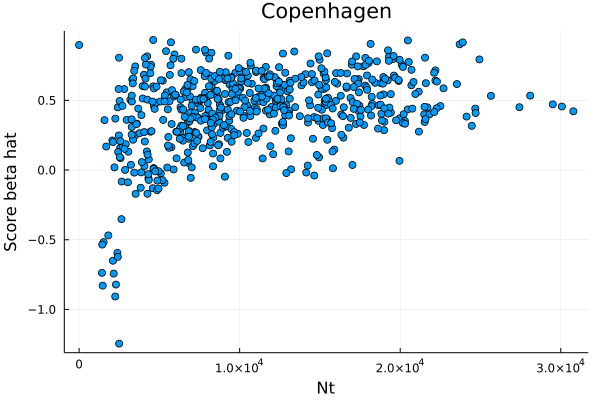

In [118]:
@df Copenhagen scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Copenhagen", xlabel = "Nt", ylabel = "Score beta hat")

### Section 3.3.2: Weekly

#### Cross-sectional

In [119]:
# Calculate positive-ratio for each municipality, panel data
muni_weekly_PosRatio = DataFrame(); 
for i in 1 : Int((ncol(muni_weekly_level)-1)/2)
    Ct = muni_weekly_level[:, i+1];
    city_name = names(muni_weekly_level)[i + 1];
    Nt = muni_weekly_level[:, string(city_name, "_1")];
    ratio = Ct ./ Nt;
    muni_weekly_PosRatio[!, city_name] = ratio;
end
insertcols!(muni_weekly_PosRatio, 1, :Date => muni_weekly_level.Date);
for col in eachcol(muni_weekly_PosRatio)
    replace!(col, NaN => 0, Inf => 0);  # When Nt are 0, replace the ratio to be 0 instead of NaN and Inf.
end

# Create a dataframe contain averaged Nt and PosRatio and OLS estimates, cross-sectional data
d1 = @pipe DataFrame(City = names(muni_Nt, Not(:Date)),
          AveNt = mean.(eachcol(muni_Nt[:, Not(:Date)]))); 
d2 = @pipe DataFrame(City = names(muni_weekly_PosRatio, Not(:Date)),
          AveRatio = Float64.(mean.(eachcol(muni_weekly_PosRatio[:, Not(:Date)]))));
ols_nt_ratio_muni_weekly = @pipe leftjoin(ols_muni_weekly_coef, d1, on = :City) |> 
leftjoin(_, d2, on = :City);

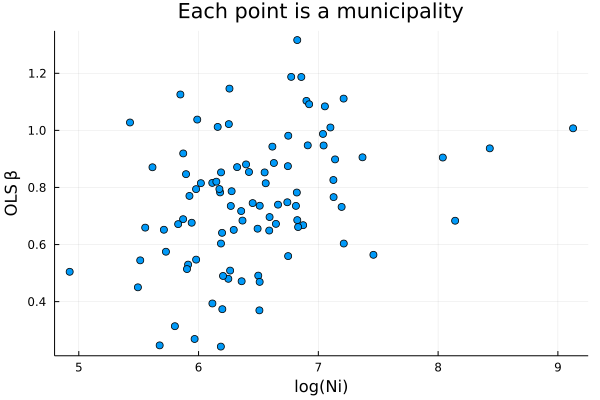

In [120]:
@df ols_nt_ratio_muni_weekly scatter(log.(:AveNt), :OLS_Slope, 
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

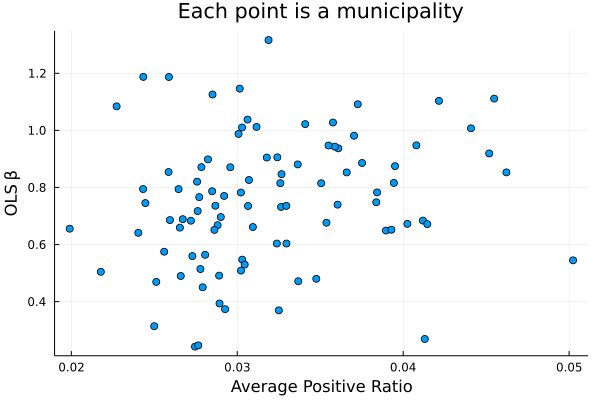

In [121]:
@df ols_nt_ratio_muni_weekly scatter(:AveRatio, :OLS_Slope, 
    label = :none, 
    xlabel = "Average Positive Ratio", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [122]:
ols_muni_weekly_beta_ratio_cross_sectional = lm(@formula(OLS_Slope ~ AveRatio + log(AveNt)), 
    ols_nt_ratio_muni_weekly)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

OLS_Slope ~ 1 + AveRatio + :(log(AveNt))

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.180925   0.238106   -0.76    0.4493  -0.653893    0.292044
AveRatio      5.71346    3.68879     1.55    0.1249  -1.61387    13.0408
log(AveNt)    0.116209   0.0341857   3.40    0.0010   0.0483031   0.184115
──────────────────────────────────────────────────────────────────────────

### Section 3.3.3: Weekday

#### Cross-sectional

In [123]:
ols_nt_ratio_muni_7dd = @pipe leftjoin(ols_muni_7dd_coef, d1, on = :City) |> 
leftjoin(_, d2, on = :City);

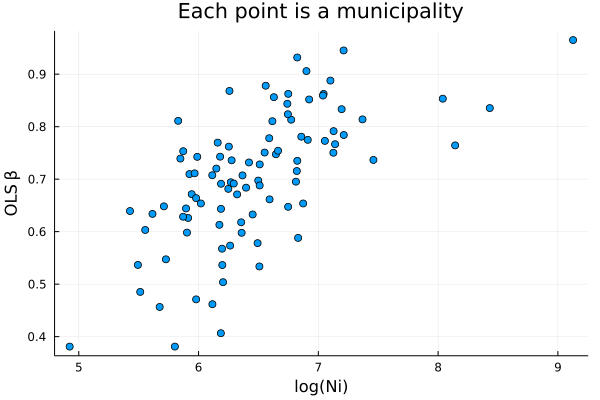

In [124]:
@df ols_nt_ratio_muni_7dd scatter(log.(:AveNt), :OLS_Slope, 
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

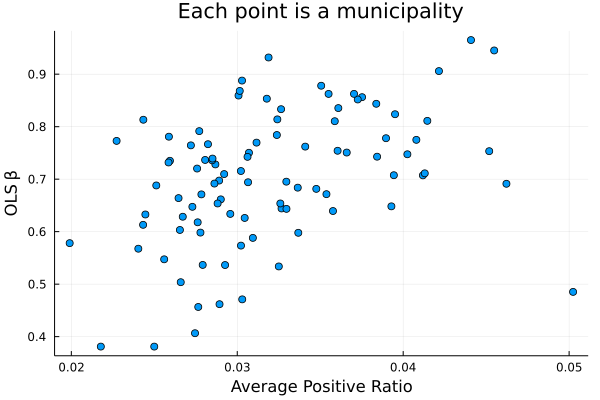

In [125]:
@df ols_nt_ratio_muni_7dd scatter(:AveRatio, :OLS_Slope, 
    label = :none, 
    xlabel = "Average Positive Ratio", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [126]:
ols_muni_7dd_beta_ratio_cross_sectional = lm(@formula(OLS_Slope ~ AveRatio + log(AveNt)), 
    ols_nt_ratio_muni_7dd)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

OLS_Slope ~ 1 + AveRatio + :(log(AveNt))

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -0.267631   0.0993332  -2.69    0.0084  -0.464944  -0.070318
AveRatio      6.81831    1.53889     4.43    <1e-04   3.76149    9.87513
log(AveNt)    0.116184   0.0142616   8.15    <1e-11   0.087855   0.144513
─────────────────────────────────────────────────────────────────────────

#### Time-series

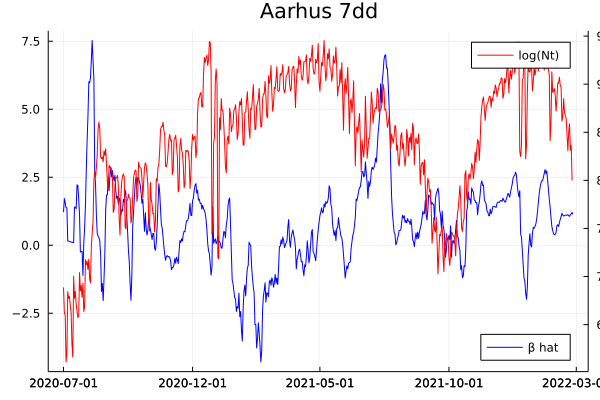

In [127]:
Aarhus_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Aarhus" => "Nt"), 
    select(muni_7dd_score_beta_restricted, :Date, "Aarhus" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aarhus" => "Ct"), 
    on = :Date => :Date);
Aarhus_7dd.PosRatio = Aarhus_7dd.Ct ./ Aarhus_7dd.Nt;
@df Aarhus_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aarhus 7dd", color = "blue", leg = :bottomright)
@df Aarhus_7dd plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

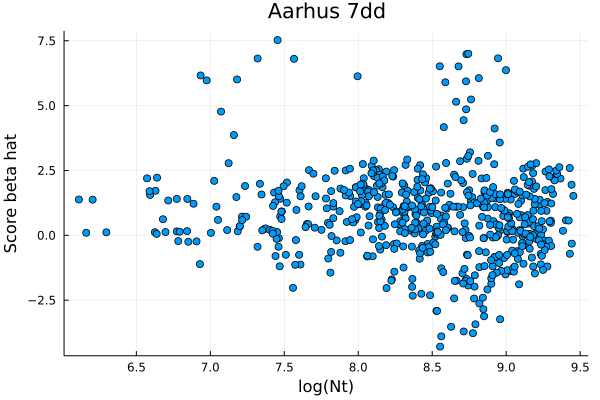

In [128]:
@df Aarhus_7dd scatter(log.(:Nt), :ScoreBetaHat, label = :none, 
    title = "Aarhus 7dd", xlabel = "log(Nt)", ylabel = "Score beta hat")

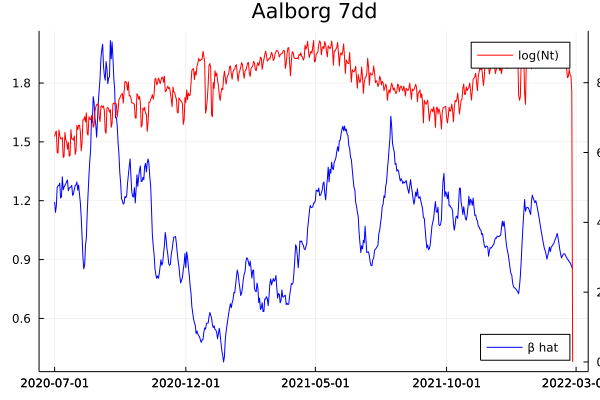

In [129]:
Aalborg_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Aalborg" => "Nt"), 
    select(muni_7dd_score_beta_restricted, :Date, "Aalborg" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aalborg" => "Ct"), 
    on = :Date => :Date);
Aalborg_7dd.PosRatio = Aalborg_7dd.Ct ./ Aalborg_7dd.Nt;
@df Aalborg_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aalborg 7dd", color = "blue", leg = :bottomright)
@df Aalborg_7dd plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

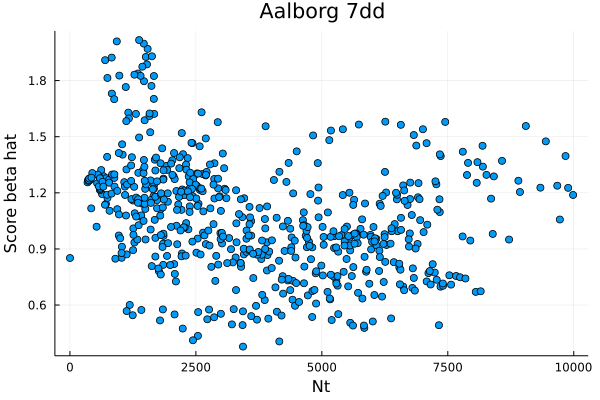

In [130]:
@df Aalborg_7dd scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Aalborg 7dd", xlabel = "Nt", ylabel = "Score beta hat")

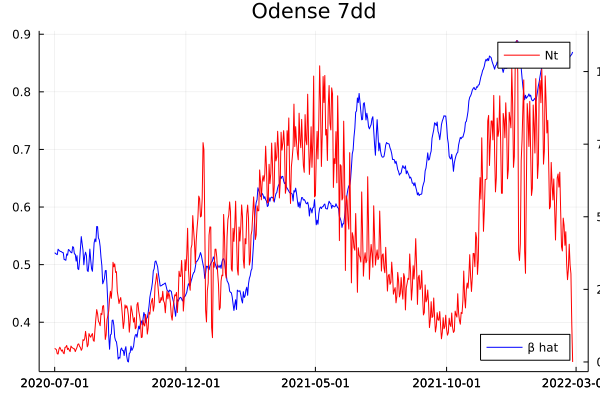

In [131]:
Odense_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Odense" => "Nt"), 
    select(muni_7dd_score_beta_restricted, :Date, "Odense" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Odense" => "Ct"), 
    on = :Date => :Date);
Odense_7dd.PosRatio = Odense_7dd.Ct ./ Odense_7dd.Nt;
@df Odense_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Odense 7dd", color = "blue", leg = :bottomright)
@df Odense_7dd plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

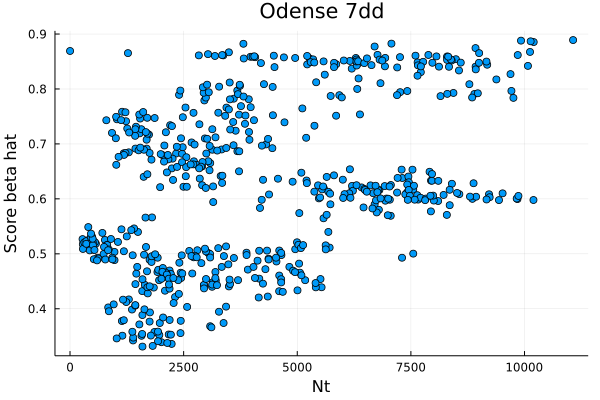

In [132]:
@df Odense_7dd scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Odense 7dd", xlabel = "Nt", ylabel = "Score beta hat")

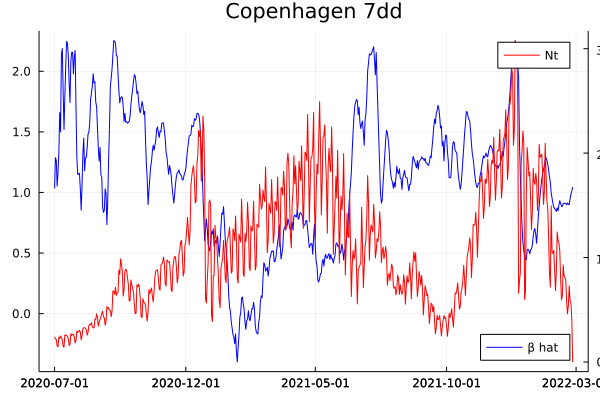

In [133]:
Copenhagen_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Copenhagen" => "Nt"), 
    select(muni_7dd_score_beta_restricted, :Date, "Copenhagen" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Copenhagen" => "Ct"), 
    on = :Date => :Date);
Copenhagen_7dd.PosRatio = Copenhagen_7dd.Ct ./ Copenhagen_7dd.Nt;
@df Copenhagen_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Copenhagen 7dd", color = "blue", leg = :bottomright)
@df Copenhagen_7dd plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

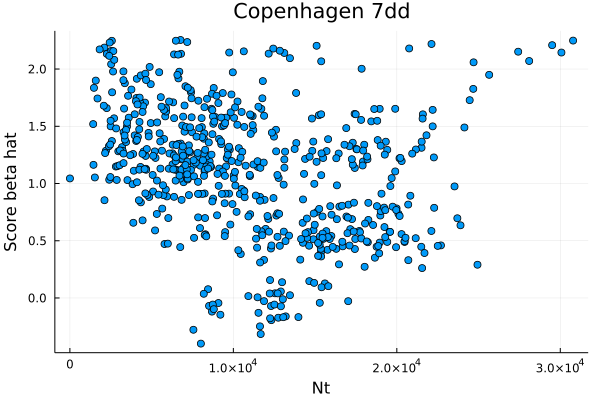

In [134]:
@df Copenhagen_7dd scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Copenhagen 7dd", xlabel = "Nt", ylabel = "Score beta hat")